In [1]:
from pycaret.regression import load_model, predict_model

In [2]:
import re
import pandas as pd

def correct_lgbm_names(df) -> pd.DataFrame:
    # Change columns names ([LightGBM] Do not support special JSON characters in feature name.)
    new_names = {col: re.sub(r"[^A-Za-z0-9_]+", "", col) for col in df.columns}
    new_n_list = list(new_names.values())
    # [LightGBM] Feature appears more than one time.
    new_names = {
        col: f"{new_col}_{i}" if new_col in new_n_list[:i] else new_col
        for i, (col, new_col) in enumerate(new_names.items())
    }
    return df.rename(columns=new_names)
    

def correct_features(original_df, model_features):
    
    corrected_df = correct_lgbm_names(original_df)
    
    # Add columns which (for some reason) are not present but are required by the trained model's pipeline
    # Default value "None"
    for feat in model_features:
        found_in_model = feat in corrected_df
        if not found_in_model:
            print(feat)
            if feat != 'label':
                corrected_df[feat] = None
    return corrected_df

In [3]:
from src.featurizers.tsfresh import TsfreshFeaturizer

def featurize_stream_df(stream_df, window, horizon):
    featurizer = TsfreshFeaturizer(stream_df.tail(window), window, horizon, plot_chunks=False, minimal_features=False)
    featurizer.chunks = 1
    featurizer.create_feature_dataframe()
    return featurizer.feature_dataframe

In [4]:
from pycaret.regression import load_model, predict_model, pull
from src.bgc_providers.ohio_bgc_provider import OhioBgcProvider
from datetime import datetime, timedelta
import pandas as pd

model = load_model('models/559_6_6_1_LGBMRegressor_8ef033d3-ac4b-47ba-8231-fb49991f8b7f')
saved_model_features = model.feature_names_in_

provider = OhioBgcProvider()
measurements = provider.tsfresh_dataframe()

stream = pd.DataFrame()

max_data = 300
meas_list = []
predictions = []
for counter in range(max_data):
    measurement = measurements.iloc[counter]
    meas_list.append(measurement)
    if len(meas_list) >= 6:
        last_n = meas_list[-6:]
        stream = pd.DataFrame(last_n).reset_index(drop=True)
        print(stream)
        features = featurize_stream_df(stream, 6, 6)
        # features
        prediction = predict_model(model, correct_features(features, saved_model_features)).prediction_label[0]
        print(prediction)
        predictions.append({
            'prediction_origin_time': measurement.date_time,
            'prediction_time': measurement.date_time + timedelta(minutes=6*5),
            'prediction_value': prediction,
        })
predictions

        


Transformation Pipeline and Model Successfully Loaded
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 01:17:00  2021-12-07    01:17:00  late night  0.00       101  a
1 2021-12-07 01:22:00  2021-12-07    01:22:00  late night  0.08        98  a
2 2021-12-07 01:27:00  2021-12-07    01:27:00  late night  0.17       104  a
3 2021-12-07 01:32:00  2021-12-07    01:32:00  late night  0.25       112  a
4 2021-12-07 01:37:00  2021-12-07    01:37:00  late night  0.33       120  a
5 2021-12-07 01:42:00  2021-12-07    01:42:00  late night  0.42       127  a


100%|██████████| 1/1 [00:11<00:00, 11.64s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
147.2868736564205
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 01:22:00  2021-12-07    01:22:00  late night  0.08        98  a
1 2021-12-07 01:27:00  2021-12-07    01:27:00  late night  0.17       104  a
2 2021-12-07 01:32:00  2021-12-07    01:32:00  late night  0.25       112  a
3 2021-12-07 01:37:00  2021-12-07    01:37:00  late night  0.33       120  a
4 2021-12-07 01:42:00  2021-12-07    01:42:00  late night  0.42       127  a
5 2021-12-07 01:47:00  2021-12-07    01:47:00  late night  0.50       135  a


100%|██████████| 1/1 [00:12<00:00, 12.19s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
156.47908464371034
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 01:27:00  2021-12-07    01:27:00  late night  0.17       104  a
1 2021-12-07 01:32:00  2021-12-07    01:32:00  late night  0.25       112  a
2 2021-12-07 01:37:00  2021-12-07    01:37:00  late night  0.33       120  a
3 2021-12-07 01:42:00  2021-12-07    01:42:00  late night  0.42       127  a
4 2021-12-07 01:47:00  2021-12-07    01:47:00  late night  0.50       135  a
5 2021-12-07 01:52:00  2021-12-07    01:52:00  late night  0.58       142  a


100%|██████████| 1/1 [00:14<00:00, 14.04s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
166.68020276724874
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 01:32:00  2021-12-07    01:32:00  late night  0.25       112  a
1 2021-12-07 01:37:00  2021-12-07    01:37:00  late night  0.33       120  a
2 2021-12-07 01:42:00  2021-12-07    01:42:00  late night  0.42       127  a
3 2021-12-07 01:47:00  2021-12-07    01:47:00  late night  0.50       135  a
4 2021-12-07 01:52:00  2021-12-07    01:52:00  late night  0.58       142  a
5 2021-12-07 01:57:00  2021-12-07    01:57:00  late night  0.67       140  a


100%|██████████| 1/1 [00:11<00:00, 11.99s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
137.05337284255495
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 01:37:00  2021-12-07    01:37:00  late night  0.33       120  a
1 2021-12-07 01:42:00  2021-12-07    01:42:00  late night  0.42       127  a
2 2021-12-07 01:47:00  2021-12-07    01:47:00  late night  0.50       135  a
3 2021-12-07 01:52:00  2021-12-07    01:52:00  late night  0.58       142  a
4 2021-12-07 01:57:00  2021-12-07    01:57:00  late night  0.67       140  a
5 2021-12-07 02:02:00  2021-12-07    02:02:00  late night  0.75       145  a


100%|██████████| 1/1 [00:14<00:00, 14.12s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
157.93776991982446
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 01:42:00  2021-12-07    01:42:00  late night  0.42       127  a
1 2021-12-07 01:47:00  2021-12-07    01:47:00  late night  0.50       135  a
2 2021-12-07 01:52:00  2021-12-07    01:52:00  late night  0.58       142  a
3 2021-12-07 01:57:00  2021-12-07    01:57:00  late night  0.67       140  a
4 2021-12-07 02:02:00  2021-12-07    02:02:00  late night  0.75       145  a
5 2021-12-07 02:07:00  2021-12-07    02:07:00  late night  0.83       148  a


100%|██████████| 1/1 [00:12<00:00, 12.16s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
147.30249923222078
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 01:47:00  2021-12-07    01:47:00  late night  0.50       135  a
1 2021-12-07 01:52:00  2021-12-07    01:52:00  late night  0.58       142  a
2 2021-12-07 01:57:00  2021-12-07    01:57:00  late night  0.67       140  a
3 2021-12-07 02:02:00  2021-12-07    02:02:00  late night  0.75       145  a
4 2021-12-07 02:07:00  2021-12-07    02:07:00  late night  0.83       148  a
5 2021-12-07 02:12:00  2021-12-07    02:12:00  late night  0.92       151  a


100%|██████████| 1/1 [00:11<00:00, 11.81s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
164.38411646343044
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 01:52:00  2021-12-07    01:52:00  late night  0.58       142  a
1 2021-12-07 01:57:00  2021-12-07    01:57:00  late night  0.67       140  a
2 2021-12-07 02:02:00  2021-12-07    02:02:00  late night  0.75       145  a
3 2021-12-07 02:07:00  2021-12-07    02:07:00  late night  0.83       148  a
4 2021-12-07 02:12:00  2021-12-07    02:12:00  late night  0.92       151  a
5 2021-12-07 02:17:00  2021-12-07    02:17:00  late night  1.00       150  a


100%|██████████| 1/1 [00:10<00:00, 10.78s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
149.20220954482735
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 01:57:00  2021-12-07    01:57:00  late night  0.67       140  a
1 2021-12-07 02:02:00  2021-12-07    02:02:00  late night  0.75       145  a
2 2021-12-07 02:07:00  2021-12-07    02:07:00  late night  0.83       148  a
3 2021-12-07 02:12:00  2021-12-07    02:12:00  late night  0.92       151  a
4 2021-12-07 02:17:00  2021-12-07    02:17:00  late night  1.00       150  a
5 2021-12-07 02:22:00  2021-12-07    02:22:00  late night  1.08       124  a


100%|██████████| 1/1 [00:10<00:00, 10.29s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
106.29905692776686
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 02:02:00  2021-12-07    02:02:00  late night  0.75       145  a
1 2021-12-07 02:07:00  2021-12-07    02:07:00  late night  0.83       148  a
2 2021-12-07 02:12:00  2021-12-07    02:12:00  late night  0.92       151  a
3 2021-12-07 02:17:00  2021-12-07    02:17:00  late night  1.00       150  a
4 2021-12-07 02:22:00  2021-12-07    02:22:00  late night  1.08       124  a
5 2021-12-07 02:27:00  2021-12-07    02:27:00  late night  1.17       130  a


100%|██████████| 1/1 [00:10<00:00, 10.40s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
118.9727198535413
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 02:07:00  2021-12-07    02:07:00  late night  0.83       148  a
1 2021-12-07 02:12:00  2021-12-07    02:12:00  late night  0.92       151  a
2 2021-12-07 02:17:00  2021-12-07    02:17:00  late night  1.00       150  a
3 2021-12-07 02:22:00  2021-12-07    02:22:00  late night  1.08       124  a
4 2021-12-07 02:27:00  2021-12-07    02:27:00  late night  1.17       130  a
5 2021-12-07 02:32:00  2021-12-07    02:32:00  late night  1.25       127  a


100%|██████████| 1/1 [00:10<00:00, 10.75s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
97.21683853830638
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 02:12:00  2021-12-07    02:12:00  late night  0.92       151  a
1 2021-12-07 02:17:00  2021-12-07    02:17:00  late night  1.00       150  a
2 2021-12-07 02:22:00  2021-12-07    02:22:00  late night  1.08       124  a
3 2021-12-07 02:27:00  2021-12-07    02:27:00  late night  1.17       130  a
4 2021-12-07 02:32:00  2021-12-07    02:32:00  late night  1.25       127  a
5 2021-12-07 02:37:00  2021-12-07    02:37:00  late night  1.33       121  a


100%|██████████| 1/1 [00:09<00:00,  9.98s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
93.14428727679184
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 02:17:00  2021-12-07    02:17:00  late night  1.00       150  a
1 2021-12-07 02:22:00  2021-12-07    02:22:00  late night  1.08       124  a
2 2021-12-07 02:27:00  2021-12-07    02:27:00  late night  1.17       130  a
3 2021-12-07 02:32:00  2021-12-07    02:32:00  late night  1.25       127  a
4 2021-12-07 02:37:00  2021-12-07    02:37:00  late night  1.33       121  a
5 2021-12-07 02:42:00  2021-12-07    02:42:00  late night  1.42       115  a


100%|██████████| 1/1 [00:10<00:00, 10.10s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
90.54716657998888
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 02:22:00  2021-12-07    02:22:00  late night  1.08       124  a
1 2021-12-07 02:27:00  2021-12-07    02:27:00  late night  1.17       130  a
2 2021-12-07 02:32:00  2021-12-07    02:32:00  late night  1.25       127  a
3 2021-12-07 02:37:00  2021-12-07    02:37:00  late night  1.33       121  a
4 2021-12-07 02:42:00  2021-12-07    02:42:00  late night  1.42       115  a
5 2021-12-07 02:47:00  2021-12-07    02:47:00  late night  1.50       111  a


100%|██████████| 1/1 [00:10<00:00, 10.28s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
93.99877780946768
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 02:27:00  2021-12-07    02:27:00  late night  1.17       130  a
1 2021-12-07 02:32:00  2021-12-07    02:32:00  late night  1.25       127  a
2 2021-12-07 02:37:00  2021-12-07    02:37:00  late night  1.33       121  a
3 2021-12-07 02:42:00  2021-12-07    02:42:00  late night  1.42       115  a
4 2021-12-07 02:47:00  2021-12-07    02:47:00  late night  1.50       111  a
5 2021-12-07 02:52:00  2021-12-07    02:52:00  late night  1.58       109  a


100%|██████████| 1/1 [00:10<00:00, 10.27s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
87.94435634273673
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 02:32:00  2021-12-07    02:32:00  late night  1.25       127  a
1 2021-12-07 02:37:00  2021-12-07    02:37:00  late night  1.33       121  a
2 2021-12-07 02:42:00  2021-12-07    02:42:00  late night  1.42       115  a
3 2021-12-07 02:47:00  2021-12-07    02:47:00  late night  1.50       111  a
4 2021-12-07 02:52:00  2021-12-07    02:52:00  late night  1.58       109  a
5 2021-12-07 02:57:00  2021-12-07    02:57:00  late night  1.67       103  a


100%|██████████| 1/1 [00:11<00:00, 11.22s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
89.12811355956342
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 02:37:00  2021-12-07    02:37:00  late night  1.33       121  a
1 2021-12-07 02:42:00  2021-12-07    02:42:00  late night  1.42       115  a
2 2021-12-07 02:47:00  2021-12-07    02:47:00  late night  1.50       111  a
3 2021-12-07 02:52:00  2021-12-07    02:52:00  late night  1.58       109  a
4 2021-12-07 02:57:00  2021-12-07    02:57:00  late night  1.67       103  a
5 2021-12-07 03:02:00  2021-12-07    03:02:00  late night  1.75        89  a


100%|██████████| 1/1 [00:11<00:00, 11.85s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
93.72403735043964
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 02:42:00  2021-12-07    02:42:00  late night  1.42       115  a
1 2021-12-07 02:47:00  2021-12-07    02:47:00  late night  1.50       111  a
2 2021-12-07 02:52:00  2021-12-07    02:52:00  late night  1.58       109  a
3 2021-12-07 02:57:00  2021-12-07    02:57:00  late night  1.67       103  a
4 2021-12-07 03:02:00  2021-12-07    03:02:00  late night  1.75        89  a
5 2021-12-07 03:07:00  2021-12-07    03:07:00  late night  1.83        76  a


100%|██████████| 1/1 [00:10<00:00, 10.53s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
77.32013955536637
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 02:47:00  2021-12-07    02:47:00  late night  1.50       111  a
1 2021-12-07 02:52:00  2021-12-07    02:52:00  late night  1.58       109  a
2 2021-12-07 02:57:00  2021-12-07    02:57:00  late night  1.67       103  a
3 2021-12-07 03:02:00  2021-12-07    03:02:00  late night  1.75        89  a
4 2021-12-07 03:07:00  2021-12-07    03:07:00  late night  1.83        76  a
5 2021-12-07 03:12:00  2021-12-07    03:12:00  late night  1.92        68  a


100%|██████████| 1/1 [00:11<00:00, 11.38s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
74.95078008782338
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 02:52:00  2021-12-07    02:52:00  late night  1.58       109  a
1 2021-12-07 02:57:00  2021-12-07    02:57:00  late night  1.67       103  a
2 2021-12-07 03:02:00  2021-12-07    03:02:00  late night  1.75        89  a
3 2021-12-07 03:07:00  2021-12-07    03:07:00  late night  1.83        76  a
4 2021-12-07 03:12:00  2021-12-07    03:12:00  late night  1.92        68  a
5 2021-12-07 03:17:00  2021-12-07    03:17:00  late night  2.00        64  a


100%|██████████| 1/1 [00:10<00:00, 10.35s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
69.78463715185713
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 02:57:00  2021-12-07    02:57:00  late night  1.67       103  a
1 2021-12-07 03:02:00  2021-12-07    03:02:00  late night  1.75        89  a
2 2021-12-07 03:07:00  2021-12-07    03:07:00  late night  1.83        76  a
3 2021-12-07 03:12:00  2021-12-07    03:12:00  late night  1.92        68  a
4 2021-12-07 03:17:00  2021-12-07    03:17:00  late night  2.00        64  a
5 2021-12-07 03:22:00  2021-12-07    03:22:00  late night  2.08        64  a


100%|██████████| 1/1 [00:11<00:00, 11.10s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
96.00940472268591
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 03:02:00  2021-12-07    03:02:00  late night  1.75        89  a
1 2021-12-07 03:07:00  2021-12-07    03:07:00  late night  1.83        76  a
2 2021-12-07 03:12:00  2021-12-07    03:12:00  late night  1.92        68  a
3 2021-12-07 03:17:00  2021-12-07    03:17:00  late night  2.00        64  a
4 2021-12-07 03:22:00  2021-12-07    03:22:00  late night  2.08        64  a
5 2021-12-07 03:27:00  2021-12-07    03:27:00  late night  2.17        66  a


100%|██████████| 1/1 [00:11<00:00, 11.44s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
77.64495830925961
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 03:07:00  2021-12-07    03:07:00  late night  1.83        76  a
1 2021-12-07 03:12:00  2021-12-07    03:12:00  late night  1.92        68  a
2 2021-12-07 03:17:00  2021-12-07    03:17:00  late night  2.00        64  a
3 2021-12-07 03:22:00  2021-12-07    03:22:00  late night  2.08        64  a
4 2021-12-07 03:27:00  2021-12-07    03:27:00  late night  2.17        66  a
5 2021-12-07 03:32:00  2021-12-07    03:32:00  late night  2.25        68  a


100%|██████████| 1/1 [00:11<00:00, 11.62s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
83.7500164844256
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 03:12:00  2021-12-07    03:12:00  late night  1.92        68  a
1 2021-12-07 03:17:00  2021-12-07    03:17:00  late night  2.00        64  a
2 2021-12-07 03:22:00  2021-12-07    03:22:00  late night  2.08        64  a
3 2021-12-07 03:27:00  2021-12-07    03:27:00  late night  2.17        66  a
4 2021-12-07 03:32:00  2021-12-07    03:32:00  late night  2.25        68  a
5 2021-12-07 03:37:00  2021-12-07    03:37:00  late night  2.33        68  a


100%|██████████| 1/1 [00:10<00:00, 10.54s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
86.22031720617912
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 03:17:00  2021-12-07    03:17:00  late night  2.00        64  a
1 2021-12-07 03:22:00  2021-12-07    03:22:00  late night  2.08        64  a
2 2021-12-07 03:27:00  2021-12-07    03:27:00  late night  2.17        66  a
3 2021-12-07 03:32:00  2021-12-07    03:32:00  late night  2.25        68  a
4 2021-12-07 03:37:00  2021-12-07    03:37:00  late night  2.33        68  a
5 2021-12-07 03:42:00  2021-12-07    03:42:00  late night  2.42        66  a


100%|██████████| 1/1 [00:10<00:00, 10.64s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
71.73833128705874
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 03:22:00  2021-12-07    03:22:00  late night  2.08        64  a
1 2021-12-07 03:27:00  2021-12-07    03:27:00  late night  2.17        66  a
2 2021-12-07 03:32:00  2021-12-07    03:32:00  late night  2.25        68  a
3 2021-12-07 03:37:00  2021-12-07    03:37:00  late night  2.33        68  a
4 2021-12-07 03:42:00  2021-12-07    03:42:00  late night  2.42        66  a
5 2021-12-07 03:47:00  2021-12-07    03:47:00  late night  2.50        66  a


100%|██████████| 1/1 [00:10<00:00, 10.44s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
83.00028418779172
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 03:27:00  2021-12-07    03:27:00  late night  2.17        66  a
1 2021-12-07 03:32:00  2021-12-07    03:32:00  late night  2.25        68  a
2 2021-12-07 03:37:00  2021-12-07    03:37:00  late night  2.33        68  a
3 2021-12-07 03:42:00  2021-12-07    03:42:00  late night  2.42        66  a
4 2021-12-07 03:47:00  2021-12-07    03:47:00  late night  2.50        66  a
5 2021-12-07 03:52:00  2021-12-07    03:52:00  late night  2.58        63  a


100%|██████████| 1/1 [00:10<00:00, 10.62s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
73.82186397430833
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 03:32:00  2021-12-07    03:32:00  late night  2.25        68  a
1 2021-12-07 03:37:00  2021-12-07    03:37:00  late night  2.33        68  a
2 2021-12-07 03:42:00  2021-12-07    03:42:00  late night  2.42        66  a
3 2021-12-07 03:47:00  2021-12-07    03:47:00  late night  2.50        66  a
4 2021-12-07 03:52:00  2021-12-07    03:52:00  late night  2.58        63  a
5 2021-12-07 03:57:00  2021-12-07    03:57:00  late night  2.67        65  a


100%|██████████| 1/1 [00:11<00:00, 11.86s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
78.14480464431416
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 03:37:00  2021-12-07    03:37:00  late night  2.33        68  a
1 2021-12-07 03:42:00  2021-12-07    03:42:00  late night  2.42        66  a
2 2021-12-07 03:47:00  2021-12-07    03:47:00  late night  2.50        66  a
3 2021-12-07 03:52:00  2021-12-07    03:52:00  late night  2.58        63  a
4 2021-12-07 03:57:00  2021-12-07    03:57:00  late night  2.67        65  a
5 2021-12-07 04:02:00  2021-12-07    04:02:00  late night  2.75        69  a


100%|██████████| 1/1 [00:10<00:00, 10.56s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
96.6579086996572
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 03:42:00  2021-12-07    03:42:00  late night  2.42        66  a
1 2021-12-07 03:47:00  2021-12-07    03:47:00  late night  2.50        66  a
2 2021-12-07 03:52:00  2021-12-07    03:52:00  late night  2.58        63  a
3 2021-12-07 03:57:00  2021-12-07    03:57:00  late night  2.67        65  a
4 2021-12-07 04:02:00  2021-12-07    04:02:00  late night  2.75        69  a
5 2021-12-07 04:07:00  2021-12-07    04:07:00  late night  2.83        71  a


100%|██████████| 1/1 [00:10<00:00, 10.84s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
85.46289338133592
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 03:47:00  2021-12-07    03:47:00  late night  2.50        66  a
1 2021-12-07 03:52:00  2021-12-07    03:52:00  late night  2.58        63  a
2 2021-12-07 03:57:00  2021-12-07    03:57:00  late night  2.67        65  a
3 2021-12-07 04:02:00  2021-12-07    04:02:00  late night  2.75        69  a
4 2021-12-07 04:07:00  2021-12-07    04:07:00  late night  2.83        71  a
5 2021-12-07 04:12:00  2021-12-07    04:12:00  late night  2.92        69  a


100%|██████████| 1/1 [00:10<00:00, 10.67s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
84.77868344110212
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 03:52:00  2021-12-07    03:52:00  late night  2.58        63  a
1 2021-12-07 03:57:00  2021-12-07    03:57:00  late night  2.67        65  a
2 2021-12-07 04:02:00  2021-12-07    04:02:00  late night  2.75        69  a
3 2021-12-07 04:07:00  2021-12-07    04:07:00  late night  2.83        71  a
4 2021-12-07 04:12:00  2021-12-07    04:12:00  late night  2.92        69  a
5 2021-12-07 04:17:00  2021-12-07    04:17:00  late night  3.00        66  a


100%|██████████| 1/1 [00:10<00:00, 10.32s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
71.0845371844097
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 03:57:00  2021-12-07    03:57:00  late night  2.67        65  a
1 2021-12-07 04:02:00  2021-12-07    04:02:00  late night  2.75        69  a
2 2021-12-07 04:07:00  2021-12-07    04:07:00  late night  2.83        71  a
3 2021-12-07 04:12:00  2021-12-07    04:12:00  late night  2.92        69  a
4 2021-12-07 04:17:00  2021-12-07    04:17:00  late night  3.00        66  a
5 2021-12-07 04:22:00  2021-12-07    04:22:00  late night  3.08        65  a


100%|██████████| 1/1 [00:10<00:00, 10.49s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
75.58648643425653
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 04:02:00  2021-12-07    04:02:00  late night  2.75        69  a
1 2021-12-07 04:07:00  2021-12-07    04:07:00  late night  2.83        71  a
2 2021-12-07 04:12:00  2021-12-07    04:12:00  late night  2.92        69  a
3 2021-12-07 04:17:00  2021-12-07    04:17:00  late night  3.00        66  a
4 2021-12-07 04:22:00  2021-12-07    04:22:00  late night  3.08        65  a
5 2021-12-07 04:27:00  2021-12-07    04:27:00  late night  3.17        64  a


100%|██████████| 1/1 [00:10<00:00, 10.82s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
80.69254869947139
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 04:07:00  2021-12-07    04:07:00  late night  2.83        71  a
1 2021-12-07 04:12:00  2021-12-07    04:12:00  late night  2.92        69  a
2 2021-12-07 04:17:00  2021-12-07    04:17:00  late night  3.00        66  a
3 2021-12-07 04:22:00  2021-12-07    04:22:00  late night  3.08        65  a
4 2021-12-07 04:27:00  2021-12-07    04:27:00  late night  3.17        64  a
5 2021-12-07 04:32:00  2021-12-07    04:32:00  late night  3.25        63  a


100%|██████████| 1/1 [00:11<00:00, 11.35s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
72.05249997445877
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 04:12:00  2021-12-07    04:12:00  late night  2.92        69  a
1 2021-12-07 04:17:00  2021-12-07    04:17:00  late night  3.00        66  a
2 2021-12-07 04:22:00  2021-12-07    04:22:00  late night  3.08        65  a
3 2021-12-07 04:27:00  2021-12-07    04:27:00  late night  3.17        64  a
4 2021-12-07 04:32:00  2021-12-07    04:32:00  late night  3.25        63  a
5 2021-12-07 04:37:00  2021-12-07    04:37:00  late night  3.33        62  a


100%|██████████| 1/1 [00:10<00:00, 10.51s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
70.07889961184331
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 04:17:00  2021-12-07    04:17:00  late night  3.00        66  a
1 2021-12-07 04:22:00  2021-12-07    04:22:00  late night  3.08        65  a
2 2021-12-07 04:27:00  2021-12-07    04:27:00  late night  3.17        64  a
3 2021-12-07 04:32:00  2021-12-07    04:32:00  late night  3.25        63  a
4 2021-12-07 04:37:00  2021-12-07    04:37:00  late night  3.33        62  a
5 2021-12-07 04:42:00  2021-12-07    04:42:00  late night  3.42        62  a


100%|██████████| 1/1 [00:10<00:00, 10.90s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
69.42034965302133
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 04:22:00  2021-12-07    04:22:00  late night  3.08        65  a
1 2021-12-07 04:27:00  2021-12-07    04:27:00  late night  3.17        64  a
2 2021-12-07 04:32:00  2021-12-07    04:32:00  late night  3.25        63  a
3 2021-12-07 04:37:00  2021-12-07    04:37:00  late night  3.33        62  a
4 2021-12-07 04:42:00  2021-12-07    04:42:00  late night  3.42        62  a
5 2021-12-07 04:47:00  2021-12-07    04:47:00  late night  3.50        60  a


100%|██████████| 1/1 [00:10<00:00, 10.77s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
69.3582984147327
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 04:27:00  2021-12-07    04:27:00  late night  3.17        64  a
1 2021-12-07 04:32:00  2021-12-07    04:32:00  late night  3.25        63  a
2 2021-12-07 04:37:00  2021-12-07    04:37:00  late night  3.33        62  a
3 2021-12-07 04:42:00  2021-12-07    04:42:00  late night  3.42        62  a
4 2021-12-07 04:47:00  2021-12-07    04:47:00  late night  3.50        60  a
5 2021-12-07 04:52:00  2021-12-07    04:52:00  late night  3.58        59  a


100%|██████████| 1/1 [00:12<00:00, 12.34s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
72.79320643565079
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 04:32:00  2021-12-07    04:32:00  late night  3.25        63  a
1 2021-12-07 04:37:00  2021-12-07    04:37:00  late night  3.33        62  a
2 2021-12-07 04:42:00  2021-12-07    04:42:00  late night  3.42        62  a
3 2021-12-07 04:47:00  2021-12-07    04:47:00  late night  3.50        60  a
4 2021-12-07 04:52:00  2021-12-07    04:52:00  late night  3.58        59  a
5 2021-12-07 04:57:00  2021-12-07    04:57:00  late night  3.67        59  a


100%|██████████| 1/1 [00:11<00:00, 11.47s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
89.89151801379857
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 04:37:00  2021-12-07    04:37:00  late night  3.33        62  a
1 2021-12-07 04:42:00  2021-12-07    04:42:00  late night  3.42        62  a
2 2021-12-07 04:47:00  2021-12-07    04:47:00  late night  3.50        60  a
3 2021-12-07 04:52:00  2021-12-07    04:52:00  late night  3.58        59  a
4 2021-12-07 04:57:00  2021-12-07    04:57:00  late night  3.67        59  a
5 2021-12-07 05:02:00  2021-12-07    05:02:00  late night  3.75        59  a


100%|██████████| 1/1 [00:11<00:00, 11.55s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
85.15205821025405
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 04:42:00  2021-12-07    04:42:00  late night  3.42        62  a
1 2021-12-07 04:47:00  2021-12-07    04:47:00  late night  3.50        60  a
2 2021-12-07 04:52:00  2021-12-07    04:52:00  late night  3.58        59  a
3 2021-12-07 04:57:00  2021-12-07    04:57:00  late night  3.67        59  a
4 2021-12-07 05:02:00  2021-12-07    05:02:00  late night  3.75        59  a
5 2021-12-07 05:07:00  2021-12-07    05:07:00  late night  3.83        67  a


100%|██████████| 1/1 [00:11<00:00, 11.97s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
105.40225704638316
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 04:47:00  2021-12-07    04:47:00  late night  3.50        60  a
1 2021-12-07 04:52:00  2021-12-07    04:52:00  late night  3.58        59  a
2 2021-12-07 04:57:00  2021-12-07    04:57:00  late night  3.67        59  a
3 2021-12-07 05:02:00  2021-12-07    05:02:00  late night  3.75        59  a
4 2021-12-07 05:07:00  2021-12-07    05:07:00  late night  3.83        67  a
5 2021-12-07 05:12:00  2021-12-07    05:12:00  late night  3.92        83  a


100%|██████████| 1/1 [00:10<00:00, 10.41s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
131.50412577400175
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 04:52:00  2021-12-07    04:52:00  late night  3.58        59  a
1 2021-12-07 04:57:00  2021-12-07    04:57:00  late night  3.67        59  a
2 2021-12-07 05:02:00  2021-12-07    05:02:00  late night  3.75        59  a
3 2021-12-07 05:07:00  2021-12-07    05:07:00  late night  3.83        67  a
4 2021-12-07 05:12:00  2021-12-07    05:12:00  late night  3.92        83  a
5 2021-12-07 05:17:00  2021-12-07    05:17:00  late night  4.00        98  a


100%|██████████| 1/1 [00:11<00:00, 11.62s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
134.81153816141008
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 04:57:00  2021-12-07    04:57:00  late night  3.67        59  a
1 2021-12-07 05:02:00  2021-12-07    05:02:00  late night  3.75        59  a
2 2021-12-07 05:07:00  2021-12-07    05:07:00  late night  3.83        67  a
3 2021-12-07 05:12:00  2021-12-07    05:12:00  late night  3.92        83  a
4 2021-12-07 05:17:00  2021-12-07    05:17:00  late night  4.00        98  a
5 2021-12-07 05:22:00  2021-12-07    05:22:00  late night  4.08       110  a


100%|██████████| 1/1 [00:11<00:00, 12.00s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
146.13299985643278
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 05:02:00  2021-12-07    05:02:00  late night  3.75        59  a
1 2021-12-07 05:07:00  2021-12-07    05:07:00  late night  3.83        67  a
2 2021-12-07 05:12:00  2021-12-07    05:12:00  late night  3.92        83  a
3 2021-12-07 05:17:00  2021-12-07    05:17:00  late night  4.00        98  a
4 2021-12-07 05:22:00  2021-12-07    05:22:00  late night  4.08       110  a
5 2021-12-07 05:27:00  2021-12-07    05:27:00  late night  4.17       154  a


100%|██████████| 1/1 [00:11<00:00, 11.99s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
170.66091116618594
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 05:07:00  2021-12-07    05:07:00  late night  3.83        67  a
1 2021-12-07 05:12:00  2021-12-07    05:12:00  late night  3.92        83  a
2 2021-12-07 05:17:00  2021-12-07    05:17:00  late night  4.00        98  a
3 2021-12-07 05:22:00  2021-12-07    05:22:00  late night  4.08       110  a
4 2021-12-07 05:27:00  2021-12-07    05:27:00  late night  4.17       154  a
5 2021-12-07 05:32:00  2021-12-07    05:32:00  late night  4.25       130  a


100%|██████████| 1/1 [00:11<00:00, 11.36s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
113.93644835924201
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 05:12:00  2021-12-07    05:12:00  late night  3.92        83  a
1 2021-12-07 05:17:00  2021-12-07    05:17:00  late night  4.00        98  a
2 2021-12-07 05:22:00  2021-12-07    05:22:00  late night  4.08       110  a
3 2021-12-07 05:27:00  2021-12-07    05:27:00  late night  4.17       154  a
4 2021-12-07 05:32:00  2021-12-07    05:32:00  late night  4.25       130  a
5 2021-12-07 05:37:00  2021-12-07    05:37:00  late night  4.33       121  a


100%|██████████| 1/1 [00:10<00:00, 10.34s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
118.7802258201477
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 05:17:00  2021-12-07    05:17:00  late night  4.00        98  a
1 2021-12-07 05:22:00  2021-12-07    05:22:00  late night  4.08       110  a
2 2021-12-07 05:27:00  2021-12-07    05:27:00  late night  4.17       154  a
3 2021-12-07 05:32:00  2021-12-07    05:32:00  late night  4.25       130  a
4 2021-12-07 05:37:00  2021-12-07    05:37:00  late night  4.33       121  a
5 2021-12-07 05:42:00  2021-12-07    05:42:00  late night  4.42       110  a


100%|██████████| 1/1 [00:10<00:00, 10.79s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
149.0613678664389
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 05:22:00  2021-12-07    05:22:00  late night  4.08       110  a
1 2021-12-07 05:27:00  2021-12-07    05:27:00  late night  4.17       154  a
2 2021-12-07 05:32:00  2021-12-07    05:32:00  late night  4.25       130  a
3 2021-12-07 05:37:00  2021-12-07    05:37:00  late night  4.33       121  a
4 2021-12-07 05:42:00  2021-12-07    05:42:00  late night  4.42       110  a
5 2021-12-07 05:47:00  2021-12-07    05:47:00  late night  4.50       106  a


100%|██████████| 1/1 [00:11<00:00, 11.60s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
117.86449569135121
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 05:27:00  2021-12-07    05:27:00  late night  4.17       154  a
1 2021-12-07 05:32:00  2021-12-07    05:32:00  late night  4.25       130  a
2 2021-12-07 05:37:00  2021-12-07    05:37:00  late night  4.33       121  a
3 2021-12-07 05:42:00  2021-12-07    05:42:00  late night  4.42       110  a
4 2021-12-07 05:47:00  2021-12-07    05:47:00  late night  4.50       106  a
5 2021-12-07 05:52:00  2021-12-07    05:52:00  late night  4.58       103  a


100%|██████████| 1/1 [00:11<00:00, 11.21s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
101.02840893431988
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 05:32:00  2021-12-07    05:32:00  late night  4.25       130  a
1 2021-12-07 05:37:00  2021-12-07    05:37:00  late night  4.33       121  a
2 2021-12-07 05:42:00  2021-12-07    05:42:00  late night  4.42       110  a
3 2021-12-07 05:47:00  2021-12-07    05:47:00  late night  4.50       106  a
4 2021-12-07 05:52:00  2021-12-07    05:52:00  late night  4.58       103  a
5 2021-12-07 05:57:00  2021-12-07    05:57:00  late night  4.67       103  a


100%|██████████| 1/1 [00:10<00:00, 10.41s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
97.08545034108228
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 05:37:00  2021-12-07    05:37:00  late night  4.33       121  a
1 2021-12-07 05:42:00  2021-12-07    05:42:00  late night  4.42       110  a
2 2021-12-07 05:47:00  2021-12-07    05:47:00  late night  4.50       106  a
3 2021-12-07 05:52:00  2021-12-07    05:52:00  late night  4.58       103  a
4 2021-12-07 05:57:00  2021-12-07    05:57:00  late night  4.67       103  a
5 2021-12-07 06:02:00  2021-12-07    06:02:00  late night  4.75       108  a


100%|██████████| 1/1 [00:10<00:00, 10.89s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
108.20676355569735
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 05:42:00  2021-12-07    05:42:00  late night  4.42       110  a
1 2021-12-07 05:47:00  2021-12-07    05:47:00  late night  4.50       106  a
2 2021-12-07 05:52:00  2021-12-07    05:52:00  late night  4.58       103  a
3 2021-12-07 05:57:00  2021-12-07    05:57:00  late night  4.67       103  a
4 2021-12-07 06:02:00  2021-12-07    06:02:00  late night  4.75       108  a
5 2021-12-07 06:07:00  2021-12-07    06:07:00  late night  4.83       116  a


100%|██████████| 1/1 [00:10<00:00, 10.46s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
125.1936771472034
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 05:47:00  2021-12-07    05:47:00  late night  4.50       106  a
1 2021-12-07 05:52:00  2021-12-07    05:52:00  late night  4.58       103  a
2 2021-12-07 05:57:00  2021-12-07    05:57:00  late night  4.67       103  a
3 2021-12-07 06:02:00  2021-12-07    06:02:00  late night  4.75       108  a
4 2021-12-07 06:07:00  2021-12-07    06:07:00  late night  4.83       116  a
5 2021-12-07 06:12:00  2021-12-07    06:12:00  late night  4.92       121  a


100%|██████████| 1/1 [00:10<00:00, 10.06s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
132.1510998785065
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 05:52:00  2021-12-07    05:52:00  late night  4.58       103  a
1 2021-12-07 05:57:00  2021-12-07    05:57:00  late night  4.67       103  a
2 2021-12-07 06:02:00  2021-12-07    06:02:00  late night  4.75       108  a
3 2021-12-07 06:07:00  2021-12-07    06:07:00  late night  4.83       116  a
4 2021-12-07 06:12:00  2021-12-07    06:12:00  late night  4.92       121  a
5 2021-12-07 06:17:00  2021-12-07    06:17:00  late night  5.00       123  a


100%|██████████| 1/1 [00:10<00:00, 10.28s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
124.0937549142772
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 05:57:00  2021-12-07    05:57:00  late night  4.67       103  a
1 2021-12-07 06:02:00  2021-12-07    06:02:00  late night  4.75       108  a
2 2021-12-07 06:07:00  2021-12-07    06:07:00  late night  4.83       116  a
3 2021-12-07 06:12:00  2021-12-07    06:12:00  late night  4.92       121  a
4 2021-12-07 06:17:00  2021-12-07    06:17:00  late night  5.00       123  a
5 2021-12-07 06:22:00  2021-12-07    06:22:00  late night  5.08       117  a


100%|██████████| 1/1 [00:11<00:00, 11.02s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
117.21931185490931
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 06:02:00  2021-12-07    06:02:00  late night  4.75       108  a
1 2021-12-07 06:07:00  2021-12-07    06:07:00  late night  4.83       116  a
2 2021-12-07 06:12:00  2021-12-07    06:12:00  late night  4.92       121  a
3 2021-12-07 06:17:00  2021-12-07    06:17:00  late night  5.00       123  a
4 2021-12-07 06:22:00  2021-12-07    06:22:00  late night  5.08       117  a
5 2021-12-07 06:27:00  2021-12-07    06:27:00  late night  5.17       109  a


100%|██████████| 1/1 [00:10<00:00, 10.57s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
78.9314951976324
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 06:07:00  2021-12-07    06:07:00  late night  4.83       116  a
1 2021-12-07 06:12:00  2021-12-07    06:12:00  late night  4.92       121  a
2 2021-12-07 06:17:00  2021-12-07    06:17:00  late night  5.00       123  a
3 2021-12-07 06:22:00  2021-12-07    06:22:00  late night  5.08       117  a
4 2021-12-07 06:27:00  2021-12-07    06:27:00  late night  5.17       109  a
5 2021-12-07 06:32:00  2021-12-07    06:32:00  late night  5.25        90  a


100%|██████████| 1/1 [00:10<00:00, 10.32s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
85.16352218889428
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 06:12:00  2021-12-07    06:12:00  late night  4.92       121  a
1 2021-12-07 06:17:00  2021-12-07    06:17:00  late night  5.00       123  a
2 2021-12-07 06:22:00  2021-12-07    06:22:00  late night  5.08       117  a
3 2021-12-07 06:27:00  2021-12-07    06:27:00  late night  5.17       109  a
4 2021-12-07 06:32:00  2021-12-07    06:32:00  late night  5.25        90  a
5 2021-12-07 06:37:00  2021-12-07    06:37:00  late night  5.33        80  a


100%|██████████| 1/1 [00:11<00:00, 11.13s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
88.28696225096122
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 06:17:00  2021-12-07    06:17:00  late night  5.00       123  a
1 2021-12-07 06:22:00  2021-12-07    06:22:00  late night  5.08       117  a
2 2021-12-07 06:27:00  2021-12-07    06:27:00  late night  5.17       109  a
3 2021-12-07 06:32:00  2021-12-07    06:32:00  late night  5.25        90  a
4 2021-12-07 06:37:00  2021-12-07    06:37:00  late night  5.33        80  a
5 2021-12-07 06:42:00  2021-12-07    06:42:00  late night  5.42        73  a


100%|██████████| 1/1 [00:10<00:00, 10.18s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
80.80265943076164
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 06:22:00  2021-12-07    06:22:00  late night  5.08       117  a
1 2021-12-07 06:27:00  2021-12-07    06:27:00  late night  5.17       109  a
2 2021-12-07 06:32:00  2021-12-07    06:32:00  late night  5.25        90  a
3 2021-12-07 06:37:00  2021-12-07    06:37:00  late night  5.33        80  a
4 2021-12-07 06:42:00  2021-12-07    06:42:00  late night  5.42        73  a
5 2021-12-07 06:47:00  2021-12-07    06:47:00  late night  5.50        65  a


100%|██████████| 1/1 [00:10<00:00, 10.50s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
76.02864743210687
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 06:27:00  2021-12-07    06:27:00  late night  5.17       109  a
1 2021-12-07 06:32:00  2021-12-07    06:32:00  late night  5.25        90  a
2 2021-12-07 06:37:00  2021-12-07    06:37:00  late night  5.33        80  a
3 2021-12-07 06:42:00  2021-12-07    06:42:00  late night  5.42        73  a
4 2021-12-07 06:47:00  2021-12-07    06:47:00  late night  5.50        65  a
5 2021-12-07 06:52:00  2021-12-07    06:52:00  late night  5.58        65  a


100%|██████████| 1/1 [00:10<00:00, 10.90s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
84.80929549984324
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 06:32:00  2021-12-07    06:32:00  late night  5.25        90  a
1 2021-12-07 06:37:00  2021-12-07    06:37:00  late night  5.33        80  a
2 2021-12-07 06:42:00  2021-12-07    06:42:00  late night  5.42        73  a
3 2021-12-07 06:47:00  2021-12-07    06:47:00  late night  5.50        65  a
4 2021-12-07 06:52:00  2021-12-07    06:52:00  late night  5.58        65  a
5 2021-12-07 06:57:00  2021-12-07    06:57:00  late night  5.67        65  a


100%|██████████| 1/1 [00:11<00:00, 11.40s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
84.5356855177876
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 06:37:00  2021-12-07    06:37:00  late night  5.33        80  a
1 2021-12-07 06:42:00  2021-12-07    06:42:00  late night  5.42        73  a
2 2021-12-07 06:47:00  2021-12-07    06:47:00  late night  5.50        65  a
3 2021-12-07 06:52:00  2021-12-07    06:52:00  late night  5.58        65  a
4 2021-12-07 06:57:00  2021-12-07    06:57:00  late night  5.67        65  a
5 2021-12-07 07:02:00  2021-12-07    07:02:00     morning  5.75        66  a


100%|██████████| 1/1 [00:11<00:00, 11.46s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
81.87422868667949
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 06:42:00  2021-12-07    06:42:00  late night  5.42        73  a
1 2021-12-07 06:47:00  2021-12-07    06:47:00  late night  5.50        65  a
2 2021-12-07 06:52:00  2021-12-07    06:52:00  late night  5.58        65  a
3 2021-12-07 06:57:00  2021-12-07    06:57:00  late night  5.67        65  a
4 2021-12-07 07:02:00  2021-12-07    07:02:00     morning  5.75        66  a
5 2021-12-07 07:07:00  2021-12-07    07:07:00     morning  5.83        66  a


100%|██████████| 1/1 [00:11<00:00, 11.29s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
72.32214529913134
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 06:47:00  2021-12-07    06:47:00  late night  5.50        65  a
1 2021-12-07 06:52:00  2021-12-07    06:52:00  late night  5.58        65  a
2 2021-12-07 06:57:00  2021-12-07    06:57:00  late night  5.67        65  a
3 2021-12-07 07:02:00  2021-12-07    07:02:00     morning  5.75        66  a
4 2021-12-07 07:07:00  2021-12-07    07:07:00     morning  5.83        66  a
5 2021-12-07 07:12:00  2021-12-07    07:12:00     morning  5.92        65  a


100%|██████████| 1/1 [00:11<00:00, 11.39s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
72.23768174947828
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 06:52:00  2021-12-07    06:52:00  late night  5.58        65  a
1 2021-12-07 06:57:00  2021-12-07    06:57:00  late night  5.67        65  a
2 2021-12-07 07:02:00  2021-12-07    07:02:00     morning  5.75        66  a
3 2021-12-07 07:07:00  2021-12-07    07:07:00     morning  5.83        66  a
4 2021-12-07 07:12:00  2021-12-07    07:12:00     morning  5.92        65  a
5 2021-12-07 07:17:00  2021-12-07    07:17:00     morning  6.00        72  a


100%|██████████| 1/1 [00:10<00:00, 10.85s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
84.13424127480745
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 06:57:00  2021-12-07    06:57:00  late night  5.67        65  a
1 2021-12-07 07:02:00  2021-12-07    07:02:00     morning  5.75        66  a
2 2021-12-07 07:07:00  2021-12-07    07:07:00     morning  5.83        66  a
3 2021-12-07 07:12:00  2021-12-07    07:12:00     morning  5.92        65  a
4 2021-12-07 07:17:00  2021-12-07    07:17:00     morning  6.00        72  a
5 2021-12-07 07:22:00  2021-12-07    07:22:00     morning  6.08        77  a


100%|██████████| 1/1 [00:07<00:00,  7.68s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
93.50531385668901
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 07:02:00  2021-12-07    07:02:00     morning  5.75        66  a
1 2021-12-07 07:07:00  2021-12-07    07:07:00     morning  5.83        66  a
2 2021-12-07 07:12:00  2021-12-07    07:12:00     morning  5.92        65  a
3 2021-12-07 07:17:00  2021-12-07    07:17:00     morning  6.00        72  a
4 2021-12-07 07:22:00  2021-12-07    07:22:00     morning  6.08        77  a
5 2021-12-07 07:27:00  2021-12-07    07:27:00     morning  6.17        79  a


100%|██████████| 1/1 [00:07<00:00,  7.95s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
97.87941493964507
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 07:07:00  2021-12-07    07:07:00     morning  5.83        66  a
1 2021-12-07 07:12:00  2021-12-07    07:12:00     morning  5.92        65  a
2 2021-12-07 07:17:00  2021-12-07    07:17:00     morning  6.00        72  a
3 2021-12-07 07:22:00  2021-12-07    07:22:00     morning  6.08        77  a
4 2021-12-07 07:27:00  2021-12-07    07:27:00     morning  6.17        79  a
5 2021-12-07 07:32:00  2021-12-07    07:32:00     morning  6.25        79  a


100%|██████████| 1/1 [00:06<00:00,  6.32s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
100.97103299268339
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 07:12:00  2021-12-07    07:12:00     morning  5.92        65  a
1 2021-12-07 07:17:00  2021-12-07    07:17:00     morning  6.00        72  a
2 2021-12-07 07:22:00  2021-12-07    07:22:00     morning  6.08        77  a
3 2021-12-07 07:27:00  2021-12-07    07:27:00     morning  6.17        79  a
4 2021-12-07 07:32:00  2021-12-07    07:32:00     morning  6.25        79  a
5 2021-12-07 07:37:00  2021-12-07    07:37:00     morning  6.33        72  a


100%|██████████| 1/1 [00:06<00:00,  6.33s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
77.65273705303767
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 07:17:00  2021-12-07    07:17:00     morning  6.00        72  a
1 2021-12-07 07:22:00  2021-12-07    07:22:00     morning  6.08        77  a
2 2021-12-07 07:27:00  2021-12-07    07:27:00     morning  6.17        79  a
3 2021-12-07 07:32:00  2021-12-07    07:32:00     morning  6.25        79  a
4 2021-12-07 07:37:00  2021-12-07    07:37:00     morning  6.33        72  a
5 2021-12-07 07:42:00  2021-12-07    07:42:00     morning  6.42        67  a


100%|██████████| 1/1 [00:06<00:00,  6.48s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
71.24656604478672
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 07:22:00  2021-12-07    07:22:00     morning  6.08        77  a
1 2021-12-07 07:27:00  2021-12-07    07:27:00     morning  6.17        79  a
2 2021-12-07 07:32:00  2021-12-07    07:32:00     morning  6.25        79  a
3 2021-12-07 07:37:00  2021-12-07    07:37:00     morning  6.33        72  a
4 2021-12-07 07:42:00  2021-12-07    07:42:00     morning  6.42        67  a
5 2021-12-07 07:47:00  2021-12-07    07:47:00     morning  6.50        67  a


100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
90.0583569178501
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 07:27:00  2021-12-07    07:27:00     morning  6.17        79  a
1 2021-12-07 07:32:00  2021-12-07    07:32:00     morning  6.25        79  a
2 2021-12-07 07:37:00  2021-12-07    07:37:00     morning  6.33        72  a
3 2021-12-07 07:42:00  2021-12-07    07:42:00     morning  6.42        67  a
4 2021-12-07 07:47:00  2021-12-07    07:47:00     morning  6.50        67  a
5 2021-12-07 07:52:00  2021-12-07    07:52:00     morning  6.58        69  a


100%|██████████| 1/1 [00:06<00:00,  6.49s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
85.03633105630557
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 07:32:00  2021-12-07    07:32:00     morning  6.25        79  a
1 2021-12-07 07:37:00  2021-12-07    07:37:00     morning  6.33        72  a
2 2021-12-07 07:42:00  2021-12-07    07:42:00     morning  6.42        67  a
3 2021-12-07 07:47:00  2021-12-07    07:47:00     morning  6.50        67  a
4 2021-12-07 07:52:00  2021-12-07    07:52:00     morning  6.58        69  a
5 2021-12-07 07:57:00  2021-12-07    07:57:00     morning  6.67        67  a


100%|██████████| 1/1 [00:06<00:00,  6.40s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
83.71892134216039
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 07:37:00  2021-12-07    07:37:00     morning  6.33        72  a
1 2021-12-07 07:42:00  2021-12-07    07:42:00     morning  6.42        67  a
2 2021-12-07 07:47:00  2021-12-07    07:47:00     morning  6.50        67  a
3 2021-12-07 07:52:00  2021-12-07    07:52:00     morning  6.58        69  a
4 2021-12-07 07:57:00  2021-12-07    07:57:00     morning  6.67        67  a
5 2021-12-07 08:02:00  2021-12-07    08:02:00     morning  6.75        66  a


100%|██████████| 1/1 [00:06<00:00,  6.43s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
76.24300793431736
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 07:42:00  2021-12-07    07:42:00     morning  6.42        67  a
1 2021-12-07 07:47:00  2021-12-07    07:47:00     morning  6.50        67  a
2 2021-12-07 07:52:00  2021-12-07    07:52:00     morning  6.58        69  a
3 2021-12-07 07:57:00  2021-12-07    07:57:00     morning  6.67        67  a
4 2021-12-07 08:02:00  2021-12-07    08:02:00     morning  6.75        66  a
5 2021-12-07 08:07:00  2021-12-07    08:07:00     morning  6.83        68  a


100%|██████████| 1/1 [00:06<00:00,  6.46s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
85.99511893849372
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 07:47:00  2021-12-07    07:47:00     morning  6.50        67  a
1 2021-12-07 07:52:00  2021-12-07    07:52:00     morning  6.58        69  a
2 2021-12-07 07:57:00  2021-12-07    07:57:00     morning  6.67        67  a
3 2021-12-07 08:02:00  2021-12-07    08:02:00     morning  6.75        66  a
4 2021-12-07 08:07:00  2021-12-07    08:07:00     morning  6.83        68  a
5 2021-12-07 08:12:00  2021-12-07    08:12:00     morning  6.92        68  a


100%|██████████| 1/1 [00:06<00:00,  6.82s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
81.59932378564073
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 07:52:00  2021-12-07    07:52:00     morning  6.58        69  a
1 2021-12-07 07:57:00  2021-12-07    07:57:00     morning  6.67        67  a
2 2021-12-07 08:02:00  2021-12-07    08:02:00     morning  6.75        66  a
3 2021-12-07 08:07:00  2021-12-07    08:07:00     morning  6.83        68  a
4 2021-12-07 08:12:00  2021-12-07    08:12:00     morning  6.92        68  a
5 2021-12-07 08:17:00  2021-12-07    08:17:00     morning  7.00        64  a


100%|██████████| 1/1 [00:07<00:00,  7.48s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
75.51076099626498
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 07:57:00  2021-12-07    07:57:00     morning  6.67        67  a
1 2021-12-07 08:02:00  2021-12-07    08:02:00     morning  6.75        66  a
2 2021-12-07 08:07:00  2021-12-07    08:07:00     morning  6.83        68  a
3 2021-12-07 08:12:00  2021-12-07    08:12:00     morning  6.92        68  a
4 2021-12-07 08:17:00  2021-12-07    08:17:00     morning  7.00        64  a
5 2021-12-07 08:22:00  2021-12-07    08:22:00     morning  7.08        63  a


100%|██████████| 1/1 [00:08<00:00,  8.88s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
78.54852306807324
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 08:02:00  2021-12-07    08:02:00     morning  6.75        66  a
1 2021-12-07 08:07:00  2021-12-07    08:07:00     morning  6.83        68  a
2 2021-12-07 08:12:00  2021-12-07    08:12:00     morning  6.92        68  a
3 2021-12-07 08:17:00  2021-12-07    08:17:00     morning  7.00        64  a
4 2021-12-07 08:22:00  2021-12-07    08:22:00     morning  7.08        63  a
5 2021-12-07 08:27:00  2021-12-07    08:27:00     morning  7.17        65  a


100%|██████████| 1/1 [00:13<00:00, 13.90s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
85.37588074677718
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 08:07:00  2021-12-07    08:07:00     morning  6.83        68  a
1 2021-12-07 08:12:00  2021-12-07    08:12:00     morning  6.92        68  a
2 2021-12-07 08:17:00  2021-12-07    08:17:00     morning  7.00        64  a
3 2021-12-07 08:22:00  2021-12-07    08:22:00     morning  7.08        63  a
4 2021-12-07 08:27:00  2021-12-07    08:27:00     morning  7.17        65  a
5 2021-12-07 08:32:00  2021-12-07    08:32:00     morning  7.25        63  a


100%|██████████| 1/1 [00:12<00:00, 12.28s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
81.42689425330313
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 08:12:00  2021-12-07    08:12:00     morning  6.92        68  a
1 2021-12-07 08:17:00  2021-12-07    08:17:00     morning  7.00        64  a
2 2021-12-07 08:22:00  2021-12-07    08:22:00     morning  7.08        63  a
3 2021-12-07 08:27:00  2021-12-07    08:27:00     morning  7.17        65  a
4 2021-12-07 08:32:00  2021-12-07    08:32:00     morning  7.25        63  a
5 2021-12-07 08:37:00  2021-12-07    08:37:00     morning  7.33        65  a


100%|██████████| 1/1 [00:06<00:00,  6.72s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
81.13732737898519
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 08:17:00  2021-12-07    08:17:00     morning  7.00        64  a
1 2021-12-07 08:22:00  2021-12-07    08:22:00     morning  7.08        63  a
2 2021-12-07 08:27:00  2021-12-07    08:27:00     morning  7.17        65  a
3 2021-12-07 08:32:00  2021-12-07    08:32:00     morning  7.25        63  a
4 2021-12-07 08:37:00  2021-12-07    08:37:00     morning  7.33        65  a
5 2021-12-07 08:42:00  2021-12-07    08:42:00     morning  7.42        68  a


100%|██████████| 1/1 [00:06<00:00,  6.61s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
84.43175243908381
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 08:22:00  2021-12-07    08:22:00     morning  7.08        63  a
1 2021-12-07 08:27:00  2021-12-07    08:27:00     morning  7.17        65  a
2 2021-12-07 08:32:00  2021-12-07    08:32:00     morning  7.25        63  a
3 2021-12-07 08:37:00  2021-12-07    08:37:00     morning  7.33        65  a
4 2021-12-07 08:42:00  2021-12-07    08:42:00     morning  7.42        68  a
5 2021-12-07 08:47:00  2021-12-07    08:47:00     morning  7.50        68  a


100%|██████████| 1/1 [00:06<00:00,  6.46s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
83.32242774784517
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 08:27:00  2021-12-07    08:27:00     morning  7.17        65  a
1 2021-12-07 08:32:00  2021-12-07    08:32:00     morning  7.25        63  a
2 2021-12-07 08:37:00  2021-12-07    08:37:00     morning  7.33        65  a
3 2021-12-07 08:42:00  2021-12-07    08:42:00     morning  7.42        68  a
4 2021-12-07 08:47:00  2021-12-07    08:47:00     morning  7.50        68  a
5 2021-12-07 08:52:00  2021-12-07    08:52:00     morning  7.58        68  a


100%|██████████| 1/1 [00:06<00:00,  6.38s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
82.25540280471147
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 08:32:00  2021-12-07    08:32:00     morning  7.25        63  a
1 2021-12-07 08:37:00  2021-12-07    08:37:00     morning  7.33        65  a
2 2021-12-07 08:42:00  2021-12-07    08:42:00     morning  7.42        68  a
3 2021-12-07 08:47:00  2021-12-07    08:47:00     morning  7.50        68  a
4 2021-12-07 08:52:00  2021-12-07    08:52:00     morning  7.58        68  a
5 2021-12-07 08:57:00  2021-12-07    08:57:00     morning  7.67        71  a


100%|██████████| 1/1 [00:06<00:00,  6.31s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
91.31430093999433
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 08:37:00  2021-12-07    08:37:00     morning  7.33        65  a
1 2021-12-07 08:42:00  2021-12-07    08:42:00     morning  7.42        68  a
2 2021-12-07 08:47:00  2021-12-07    08:47:00     morning  7.50        68  a
3 2021-12-07 08:52:00  2021-12-07    08:52:00     morning  7.58        68  a
4 2021-12-07 08:57:00  2021-12-07    08:57:00     morning  7.67        71  a
5 2021-12-07 09:02:00  2021-12-07    09:02:00     morning  7.75        73  a


100%|██████████| 1/1 [00:06<00:00,  6.63s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
91.00640809219166
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 08:42:00  2021-12-07    08:42:00     morning  7.42        68  a
1 2021-12-07 08:47:00  2021-12-07    08:47:00     morning  7.50        68  a
2 2021-12-07 08:52:00  2021-12-07    08:52:00     morning  7.58        68  a
3 2021-12-07 08:57:00  2021-12-07    08:57:00     morning  7.67        71  a
4 2021-12-07 09:02:00  2021-12-07    09:02:00     morning  7.75        73  a
5 2021-12-07 09:07:00  2021-12-07    09:07:00     morning  7.83        71  a


100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
79.11200561040238
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 08:47:00  2021-12-07    08:47:00     morning  7.50        68  a
1 2021-12-07 08:52:00  2021-12-07    08:52:00     morning  7.58        68  a
2 2021-12-07 08:57:00  2021-12-07    08:57:00     morning  7.67        71  a
3 2021-12-07 09:02:00  2021-12-07    09:02:00     morning  7.75        73  a
4 2021-12-07 09:07:00  2021-12-07    09:07:00     morning  7.83        71  a
5 2021-12-07 09:12:00  2021-12-07    09:12:00     morning  7.92        73  a


100%|██████████| 1/1 [00:07<00:00,  7.32s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
83.40646128904814
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 08:52:00  2021-12-07    08:52:00     morning  7.58        68  a
1 2021-12-07 08:57:00  2021-12-07    08:57:00     morning  7.67        71  a
2 2021-12-07 09:02:00  2021-12-07    09:02:00     morning  7.75        73  a
3 2021-12-07 09:07:00  2021-12-07    09:07:00     morning  7.83        71  a
4 2021-12-07 09:12:00  2021-12-07    09:12:00     morning  7.92        73  a
5 2021-12-07 09:17:00  2021-12-07    09:17:00     morning  8.00        81  a


100%|██████████| 1/1 [00:06<00:00,  6.50s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
129.24647842474602
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 08:57:00  2021-12-07    08:57:00     morning  7.67        71  a
1 2021-12-07 09:02:00  2021-12-07    09:02:00     morning  7.75        73  a
2 2021-12-07 09:07:00  2021-12-07    09:07:00     morning  7.83        71  a
3 2021-12-07 09:12:00  2021-12-07    09:12:00     morning  7.92        73  a
4 2021-12-07 09:17:00  2021-12-07    09:17:00     morning  8.00        81  a
5 2021-12-07 09:22:00  2021-12-07    09:22:00     morning  8.08        91  a


100%|██████████| 1/1 [00:06<00:00,  6.69s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
108.70278628834116
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 09:02:00  2021-12-07    09:02:00     morning  7.75        73  a
1 2021-12-07 09:07:00  2021-12-07    09:07:00     morning  7.83        71  a
2 2021-12-07 09:12:00  2021-12-07    09:12:00     morning  7.92        73  a
3 2021-12-07 09:17:00  2021-12-07    09:17:00     morning  8.00        81  a
4 2021-12-07 09:22:00  2021-12-07    09:22:00     morning  8.08        91  a
5 2021-12-07 09:27:00  2021-12-07    09:27:00     morning  8.17        90  a


100%|██████████| 1/1 [00:06<00:00,  6.74s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
114.07760466045109
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 09:07:00  2021-12-07    09:07:00     morning  7.83        71  a
1 2021-12-07 09:12:00  2021-12-07    09:12:00     morning  7.92        73  a
2 2021-12-07 09:17:00  2021-12-07    09:17:00     morning  8.00        81  a
3 2021-12-07 09:22:00  2021-12-07    09:22:00     morning  8.08        91  a
4 2021-12-07 09:27:00  2021-12-07    09:27:00     morning  8.17        90  a
5 2021-12-07 09:32:00  2021-12-07    09:32:00     morning  8.25        75  a


100%|██████████| 1/1 [00:06<00:00,  6.67s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
88.86101159630033
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 09:12:00  2021-12-07    09:12:00     morning  7.92        73  a
1 2021-12-07 09:17:00  2021-12-07    09:17:00     morning  8.00        81  a
2 2021-12-07 09:22:00  2021-12-07    09:22:00     morning  8.08        91  a
3 2021-12-07 09:27:00  2021-12-07    09:27:00     morning  8.17        90  a
4 2021-12-07 09:32:00  2021-12-07    09:32:00     morning  8.25        75  a
5 2021-12-07 09:37:00  2021-12-07    09:37:00     morning  8.33        70  a


100%|██████████| 1/1 [00:06<00:00,  6.55s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
96.28083349277018
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 09:17:00  2021-12-07    09:17:00     morning  8.00        81  a
1 2021-12-07 09:22:00  2021-12-07    09:22:00     morning  8.08        91  a
2 2021-12-07 09:27:00  2021-12-07    09:27:00     morning  8.17        90  a
3 2021-12-07 09:32:00  2021-12-07    09:32:00     morning  8.25        75  a
4 2021-12-07 09:37:00  2021-12-07    09:37:00     morning  8.33        70  a
5 2021-12-07 09:42:00  2021-12-07    09:42:00     morning  8.42        70  a


100%|██████████| 1/1 [00:06<00:00,  6.43s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
78.06358002750251
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 09:22:00  2021-12-07    09:22:00     morning  8.08        91  a
1 2021-12-07 09:27:00  2021-12-07    09:27:00     morning  8.17        90  a
2 2021-12-07 09:32:00  2021-12-07    09:32:00     morning  8.25        75  a
3 2021-12-07 09:37:00  2021-12-07    09:37:00     morning  8.33        70  a
4 2021-12-07 09:42:00  2021-12-07    09:42:00     morning  8.42        70  a
5 2021-12-07 09:47:00  2021-12-07    09:47:00     morning  8.50        68  a


100%|██████████| 1/1 [00:07<00:00,  7.25s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
77.01211478065666
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 09:27:00  2021-12-07    09:27:00     morning  8.17        90  a
1 2021-12-07 09:32:00  2021-12-07    09:32:00     morning  8.25        75  a
2 2021-12-07 09:37:00  2021-12-07    09:37:00     morning  8.33        70  a
3 2021-12-07 09:42:00  2021-12-07    09:42:00     morning  8.42        70  a
4 2021-12-07 09:47:00  2021-12-07    09:47:00     morning  8.50        68  a
5 2021-12-07 09:52:00  2021-12-07    09:52:00     morning  8.58        68  a


100%|██████████| 1/1 [00:07<00:00,  7.58s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
86.48188837922721
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 09:32:00  2021-12-07    09:32:00     morning  8.25        75  a
1 2021-12-07 09:37:00  2021-12-07    09:37:00     morning  8.33        70  a
2 2021-12-07 09:42:00  2021-12-07    09:42:00     morning  8.42        70  a
3 2021-12-07 09:47:00  2021-12-07    09:47:00     morning  8.50        68  a
4 2021-12-07 09:52:00  2021-12-07    09:52:00     morning  8.58        68  a
5 2021-12-07 09:57:00  2021-12-07    09:57:00     morning  8.67        66  a


100%|██████████| 1/1 [00:07<00:00,  7.57s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
80.00331075705725
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 09:37:00  2021-12-07    09:37:00     morning  8.33        70  a
1 2021-12-07 09:42:00  2021-12-07    09:42:00     morning  8.42        70  a
2 2021-12-07 09:47:00  2021-12-07    09:47:00     morning  8.50        68  a
3 2021-12-07 09:52:00  2021-12-07    09:52:00     morning  8.58        68  a
4 2021-12-07 09:57:00  2021-12-07    09:57:00     morning  8.67        66  a
5 2021-12-07 10:02:00  2021-12-07    10:02:00     morning  8.75        64  a


100%|██████████| 1/1 [00:06<00:00,  6.42s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
78.54189932022692
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 09:42:00  2021-12-07    09:42:00     morning  8.42        70  a
1 2021-12-07 09:47:00  2021-12-07    09:47:00     morning  8.50        68  a
2 2021-12-07 09:52:00  2021-12-07    09:52:00     morning  8.58        68  a
3 2021-12-07 09:57:00  2021-12-07    09:57:00     morning  8.67        66  a
4 2021-12-07 10:02:00  2021-12-07    10:02:00     morning  8.75        64  a
5 2021-12-07 10:07:00  2021-12-07    10:07:00     morning  8.83        63  a


100%|██████████| 1/1 [00:07<00:00,  7.42s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
78.35853358594512
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 09:47:00  2021-12-07    09:47:00     morning  8.50        68  a
1 2021-12-07 09:52:00  2021-12-07    09:52:00     morning  8.58        68  a
2 2021-12-07 09:57:00  2021-12-07    09:57:00     morning  8.67        66  a
3 2021-12-07 10:02:00  2021-12-07    10:02:00     morning  8.75        64  a
4 2021-12-07 10:07:00  2021-12-07    10:07:00     morning  8.83        63  a
5 2021-12-07 10:12:00  2021-12-07    10:12:00     morning  8.92        66  a


100%|██████████| 1/1 [00:07<00:00,  7.56s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
87.86932871498384
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 09:52:00  2021-12-07    09:52:00     morning  8.58        68  a
1 2021-12-07 09:57:00  2021-12-07    09:57:00     morning  8.67        66  a
2 2021-12-07 10:02:00  2021-12-07    10:02:00     morning  8.75        64  a
3 2021-12-07 10:07:00  2021-12-07    10:07:00     morning  8.83        63  a
4 2021-12-07 10:12:00  2021-12-07    10:12:00     morning  8.92        66  a
5 2021-12-07 10:17:00  2021-12-07    10:17:00     morning  9.00        67  a


100%|██████████| 1/1 [00:06<00:00,  6.59s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
82.84484618681817
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 09:57:00  2021-12-07    09:57:00     morning  8.67        66  a
1 2021-12-07 10:02:00  2021-12-07    10:02:00     morning  8.75        64  a
2 2021-12-07 10:07:00  2021-12-07    10:07:00     morning  8.83        63  a
3 2021-12-07 10:12:00  2021-12-07    10:12:00     morning  8.92        66  a
4 2021-12-07 10:17:00  2021-12-07    10:17:00     morning  9.00        67  a
5 2021-12-07 10:22:00  2021-12-07    10:22:00     morning  9.08        69  a


100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
87.83691371244683
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 10:02:00  2021-12-07    10:02:00     morning  8.75        64  a
1 2021-12-07 10:07:00  2021-12-07    10:07:00     morning  8.83        63  a
2 2021-12-07 10:12:00  2021-12-07    10:12:00     morning  8.92        66  a
3 2021-12-07 10:17:00  2021-12-07    10:17:00     morning  9.00        67  a
4 2021-12-07 10:22:00  2021-12-07    10:22:00     morning  9.08        69  a
5 2021-12-07 10:27:00  2021-12-07    10:27:00     morning  9.17        70  a


100%|██████████| 1/1 [00:06<00:00,  6.18s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
90.3099729998854
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 10:07:00  2021-12-07    10:07:00     morning  8.83        63  a
1 2021-12-07 10:12:00  2021-12-07    10:12:00     morning  8.92        66  a
2 2021-12-07 10:17:00  2021-12-07    10:17:00     morning  9.00        67  a
3 2021-12-07 10:22:00  2021-12-07    10:22:00     morning  9.08        69  a
4 2021-12-07 10:27:00  2021-12-07    10:27:00     morning  9.17        70  a
5 2021-12-07 10:32:00  2021-12-07    10:32:00     morning  9.25        71  a


100%|██████████| 1/1 [00:07<00:00,  7.00s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
83.21597307572038
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 10:12:00  2021-12-07    10:12:00     morning  8.92        66  a
1 2021-12-07 10:17:00  2021-12-07    10:17:00     morning  9.00        67  a
2 2021-12-07 10:22:00  2021-12-07    10:22:00     morning  9.08        69  a
3 2021-12-07 10:27:00  2021-12-07    10:27:00     morning  9.17        70  a
4 2021-12-07 10:32:00  2021-12-07    10:32:00     morning  9.25        71  a
5 2021-12-07 10:37:00  2021-12-07    10:37:00     morning  9.33        75  a


100%|██████████| 1/1 [00:05<00:00,  5.87s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
101.72691691102021
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 10:17:00  2021-12-07    10:17:00     morning  9.00        67  a
1 2021-12-07 10:22:00  2021-12-07    10:22:00     morning  9.08        69  a
2 2021-12-07 10:27:00  2021-12-07    10:27:00     morning  9.17        70  a
3 2021-12-07 10:32:00  2021-12-07    10:32:00     morning  9.25        71  a
4 2021-12-07 10:37:00  2021-12-07    10:37:00     morning  9.33        75  a
5 2021-12-07 10:42:00  2021-12-07    10:42:00     morning  9.42        74  a


100%|██████████| 1/1 [00:05<00:00,  5.70s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
84.29771932189458
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 10:22:00  2021-12-07    10:22:00     morning  9.08        69  a
1 2021-12-07 10:27:00  2021-12-07    10:27:00     morning  9.17        70  a
2 2021-12-07 10:32:00  2021-12-07    10:32:00     morning  9.25        71  a
3 2021-12-07 10:37:00  2021-12-07    10:37:00     morning  9.33        75  a
4 2021-12-07 10:42:00  2021-12-07    10:42:00     morning  9.42        74  a
5 2021-12-07 10:47:00  2021-12-07    10:47:00     morning  9.50        76  a


100%|██████████| 1/1 [00:05<00:00,  5.81s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
116.5429312287202
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 10:27:00  2021-12-07    10:27:00     morning  9.17        70  a
1 2021-12-07 10:32:00  2021-12-07    10:32:00     morning  9.25        71  a
2 2021-12-07 10:37:00  2021-12-07    10:37:00     morning  9.33        75  a
3 2021-12-07 10:42:00  2021-12-07    10:42:00     morning  9.42        74  a
4 2021-12-07 10:47:00  2021-12-07    10:47:00     morning  9.50        76  a
5 2021-12-07 10:52:00  2021-12-07    10:52:00     morning  9.58        79  a


100%|██████████| 1/1 [00:05<00:00,  5.91s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
115.66404945869871
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 10:32:00  2021-12-07    10:32:00     morning  9.25        71  a
1 2021-12-07 10:37:00  2021-12-07    10:37:00     morning  9.33        75  a
2 2021-12-07 10:42:00  2021-12-07    10:42:00     morning  9.42        74  a
3 2021-12-07 10:47:00  2021-12-07    10:47:00     morning  9.50        76  a
4 2021-12-07 10:52:00  2021-12-07    10:52:00     morning  9.58        79  a
5 2021-12-07 10:57:00  2021-12-07    10:57:00     morning  9.67        80  a


100%|██████████| 1/1 [00:07<00:00,  7.36s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
120.17832588807866
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 10:37:00  2021-12-07    10:37:00     morning  9.33        75  a
1 2021-12-07 10:42:00  2021-12-07    10:42:00     morning  9.42        74  a
2 2021-12-07 10:47:00  2021-12-07    10:47:00     morning  9.50        76  a
3 2021-12-07 10:52:00  2021-12-07    10:52:00     morning  9.58        79  a
4 2021-12-07 10:57:00  2021-12-07    10:57:00     morning  9.67        80  a
5 2021-12-07 11:02:00  2021-12-07    11:02:00     morning  9.75        92  a


100%|██████████| 1/1 [00:08<00:00,  8.03s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
187.79456883742546
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 10:42:00  2021-12-07    10:42:00     morning  9.42        74  a
1 2021-12-07 10:47:00  2021-12-07    10:47:00     morning  9.50        76  a
2 2021-12-07 10:52:00  2021-12-07    10:52:00     morning  9.58        79  a
3 2021-12-07 10:57:00  2021-12-07    10:57:00     morning  9.67        80  a
4 2021-12-07 11:02:00  2021-12-07    11:02:00     morning  9.75        92  a
5 2021-12-07 11:07:00  2021-12-07    11:07:00     morning  9.83       147  a


100%|██████████| 1/1 [00:06<00:00,  6.42s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
202.37450077964337
            date_time   mock_date time_of_day part_of_day  time  bg_value id
0 2021-12-07 10:47:00  2021-12-07    10:47:00     morning  9.50        76  a
1 2021-12-07 10:52:00  2021-12-07    10:52:00     morning  9.58        79  a
2 2021-12-07 10:57:00  2021-12-07    10:57:00     morning  9.67        80  a
3 2021-12-07 11:02:00  2021-12-07    11:02:00     morning  9.75        92  a
4 2021-12-07 11:07:00  2021-12-07    11:07:00     morning  9.83       147  a
5 2021-12-07 11:12:00  2021-12-07    11:12:00     morning  9.92       166  a


100%|██████████| 1/1 [00:06<00:00,  6.08s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
208.25034006358794
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 10:52:00  2021-12-07    10:52:00     morning   9.58        79  a
1 2021-12-07 10:57:00  2021-12-07    10:57:00     morning   9.67        80  a
2 2021-12-07 11:02:00  2021-12-07    11:02:00     morning   9.75        92  a
3 2021-12-07 11:07:00  2021-12-07    11:07:00     morning   9.83       147  a
4 2021-12-07 11:12:00  2021-12-07    11:12:00     morning   9.92       166  a
5 2021-12-07 11:17:00  2021-12-07    11:17:00     morning  10.00       213  a


100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
212.15791472836497
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 10:57:00  2021-12-07    10:57:00     morning   9.67        80  a
1 2021-12-07 11:02:00  2021-12-07    11:02:00     morning   9.75        92  a
2 2021-12-07 11:07:00  2021-12-07    11:07:00     morning   9.83       147  a
3 2021-12-07 11:12:00  2021-12-07    11:12:00     morning   9.92       166  a
4 2021-12-07 11:17:00  2021-12-07    11:17:00     morning  10.00       213  a
5 2021-12-07 11:22:00  2021-12-07    11:22:00     morning  10.08       235  a


100%|██████████| 1/1 [00:06<00:00,  6.29s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
232.7889601684728
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 11:02:00  2021-12-07    11:02:00     morning   9.75        92  a
1 2021-12-07 11:07:00  2021-12-07    11:07:00     morning   9.83       147  a
2 2021-12-07 11:12:00  2021-12-07    11:12:00     morning   9.92       166  a
3 2021-12-07 11:17:00  2021-12-07    11:17:00     morning  10.00       213  a
4 2021-12-07 11:22:00  2021-12-07    11:22:00     morning  10.08       235  a
5 2021-12-07 11:27:00  2021-12-07    11:27:00     morning  10.17       240  a


100%|██████████| 1/1 [00:06<00:00,  6.79s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
195.40777068449447
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 11:07:00  2021-12-07    11:07:00     morning   9.83       147  a
1 2021-12-07 11:12:00  2021-12-07    11:12:00     morning   9.92       166  a
2 2021-12-07 11:17:00  2021-12-07    11:17:00     morning  10.00       213  a
3 2021-12-07 11:22:00  2021-12-07    11:22:00     morning  10.08       235  a
4 2021-12-07 11:27:00  2021-12-07    11:27:00     morning  10.17       240  a
5 2021-12-07 11:32:00  2021-12-07    11:32:00     morning  10.25       232  a


100%|██████████| 1/1 [00:06<00:00,  6.36s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
231.39574985192067
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 11:12:00  2021-12-07    11:12:00     morning   9.92       166  a
1 2021-12-07 11:17:00  2021-12-07    11:17:00     morning  10.00       213  a
2 2021-12-07 11:22:00  2021-12-07    11:22:00     morning  10.08       235  a
3 2021-12-07 11:27:00  2021-12-07    11:27:00     morning  10.17       240  a
4 2021-12-07 11:32:00  2021-12-07    11:32:00     morning  10.25       232  a
5 2021-12-07 11:37:00  2021-12-07    11:37:00     morning  10.33       221  a


100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
222.69562671805292
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 11:17:00  2021-12-07    11:17:00     morning  10.00       213  a
1 2021-12-07 11:22:00  2021-12-07    11:22:00     morning  10.08       235  a
2 2021-12-07 11:27:00  2021-12-07    11:27:00     morning  10.17       240  a
3 2021-12-07 11:32:00  2021-12-07    11:32:00     morning  10.25       232  a
4 2021-12-07 11:37:00  2021-12-07    11:37:00     morning  10.33       221  a
5 2021-12-07 11:42:00  2021-12-07    11:42:00     morning  10.42       206  a


100%|██████████| 1/1 [00:07<00:00,  7.27s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
182.98085269283337
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 11:22:00  2021-12-07    11:22:00     morning  10.08       235  a
1 2021-12-07 11:27:00  2021-12-07    11:27:00     morning  10.17       240  a
2 2021-12-07 11:32:00  2021-12-07    11:32:00     morning  10.25       232  a
3 2021-12-07 11:37:00  2021-12-07    11:37:00     morning  10.33       221  a
4 2021-12-07 11:42:00  2021-12-07    11:42:00     morning  10.42       206  a
5 2021-12-07 11:47:00  2021-12-07    11:47:00     morning  10.50       194  a


100%|██████████| 1/1 [00:06<00:00,  6.57s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
158.54653436034326
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 11:27:00  2021-12-07    11:27:00     morning  10.17       240  a
1 2021-12-07 11:32:00  2021-12-07    11:32:00     morning  10.25       232  a
2 2021-12-07 11:37:00  2021-12-07    11:37:00     morning  10.33       221  a
3 2021-12-07 11:42:00  2021-12-07    11:42:00     morning  10.42       206  a
4 2021-12-07 11:47:00  2021-12-07    11:47:00     morning  10.50       194  a
5 2021-12-07 11:52:00  2021-12-07    11:52:00     morning  10.58       185  a


100%|██████████| 1/1 [00:06<00:00,  6.18s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
160.32434793453052
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 11:32:00  2021-12-07    11:32:00     morning  10.25       232  a
1 2021-12-07 11:37:00  2021-12-07    11:37:00     morning  10.33       221  a
2 2021-12-07 11:42:00  2021-12-07    11:42:00     morning  10.42       206  a
3 2021-12-07 11:47:00  2021-12-07    11:47:00     morning  10.50       194  a
4 2021-12-07 11:52:00  2021-12-07    11:52:00     morning  10.58       185  a
5 2021-12-07 11:57:00  2021-12-07    11:57:00     morning  10.67       178  a


100%|██████████| 1/1 [00:06<00:00,  6.42s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
163.56153950192893
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 11:37:00  2021-12-07    11:37:00     morning  10.33       221  a
1 2021-12-07 11:42:00  2021-12-07    11:42:00     morning  10.42       206  a
2 2021-12-07 11:47:00  2021-12-07    11:47:00     morning  10.50       194  a
3 2021-12-07 11:52:00  2021-12-07    11:52:00     morning  10.58       185  a
4 2021-12-07 11:57:00  2021-12-07    11:57:00     morning  10.67       178  a
5 2021-12-07 12:02:00  2021-12-07    12:02:00   afternoon  10.75       178  a


100%|██████████| 1/1 [00:06<00:00,  6.45s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
169.57913361577693
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 11:42:00  2021-12-07    11:42:00     morning  10.42       206  a
1 2021-12-07 11:47:00  2021-12-07    11:47:00     morning  10.50       194  a
2 2021-12-07 11:52:00  2021-12-07    11:52:00     morning  10.58       185  a
3 2021-12-07 11:57:00  2021-12-07    11:57:00     morning  10.67       178  a
4 2021-12-07 12:02:00  2021-12-07    12:02:00   afternoon  10.75       178  a
5 2021-12-07 12:07:00  2021-12-07    12:07:00   afternoon  10.83       176  a


100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
172.37910253031765
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 11:47:00  2021-12-07    11:47:00     morning  10.50       194  a
1 2021-12-07 11:52:00  2021-12-07    11:52:00     morning  10.58       185  a
2 2021-12-07 11:57:00  2021-12-07    11:57:00     morning  10.67       178  a
3 2021-12-07 12:02:00  2021-12-07    12:02:00   afternoon  10.75       178  a
4 2021-12-07 12:07:00  2021-12-07    12:07:00   afternoon  10.83       176  a
5 2021-12-07 12:12:00  2021-12-07    12:12:00   afternoon  10.92       172  a


100%|██████████| 1/1 [00:06<00:00,  6.55s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
166.185592932618
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 11:52:00  2021-12-07    11:52:00     morning  10.58       185  a
1 2021-12-07 11:57:00  2021-12-07    11:57:00     morning  10.67       178  a
2 2021-12-07 12:02:00  2021-12-07    12:02:00   afternoon  10.75       178  a
3 2021-12-07 12:07:00  2021-12-07    12:07:00   afternoon  10.83       176  a
4 2021-12-07 12:12:00  2021-12-07    12:12:00   afternoon  10.92       172  a
5 2021-12-07 12:17:00  2021-12-07    12:17:00   afternoon  11.00       174  a


100%|██████████| 1/1 [00:07<00:00,  7.52s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
174.80272782419826
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 11:57:00  2021-12-07    11:57:00     morning  10.67       178  a
1 2021-12-07 12:02:00  2021-12-07    12:02:00   afternoon  10.75       178  a
2 2021-12-07 12:07:00  2021-12-07    12:07:00   afternoon  10.83       176  a
3 2021-12-07 12:12:00  2021-12-07    12:12:00   afternoon  10.92       172  a
4 2021-12-07 12:17:00  2021-12-07    12:17:00   afternoon  11.00       174  a
5 2021-12-07 12:22:00  2021-12-07    12:22:00   afternoon  11.08       195  a


100%|██████████| 1/1 [00:06<00:00,  6.13s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
234.1089378498309
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 12:02:00  2021-12-07    12:02:00   afternoon  10.75       178  a
1 2021-12-07 12:07:00  2021-12-07    12:07:00   afternoon  10.83       176  a
2 2021-12-07 12:12:00  2021-12-07    12:12:00   afternoon  10.92       172  a
3 2021-12-07 12:17:00  2021-12-07    12:17:00   afternoon  11.00       174  a
4 2021-12-07 12:22:00  2021-12-07    12:22:00   afternoon  11.08       195  a
5 2021-12-07 12:27:00  2021-12-07    12:27:00   afternoon  11.17       193  a


100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
212.57207331202093
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 12:07:00  2021-12-07    12:07:00   afternoon  10.83       176  a
1 2021-12-07 12:12:00  2021-12-07    12:12:00   afternoon  10.92       172  a
2 2021-12-07 12:17:00  2021-12-07    12:17:00   afternoon  11.00       174  a
3 2021-12-07 12:22:00  2021-12-07    12:22:00   afternoon  11.08       195  a
4 2021-12-07 12:27:00  2021-12-07    12:27:00   afternoon  11.17       193  a
5 2021-12-07 12:32:00  2021-12-07    12:32:00   afternoon  11.25       192  a


100%|██████████| 1/1 [00:06<00:00,  6.12s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
216.48543530066598
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 12:12:00  2021-12-07    12:12:00   afternoon  10.92       172  a
1 2021-12-07 12:17:00  2021-12-07    12:17:00   afternoon  11.00       174  a
2 2021-12-07 12:22:00  2021-12-07    12:22:00   afternoon  11.08       195  a
3 2021-12-07 12:27:00  2021-12-07    12:27:00   afternoon  11.17       193  a
4 2021-12-07 12:32:00  2021-12-07    12:32:00   afternoon  11.25       192  a
5 2021-12-07 12:37:00  2021-12-07    12:37:00   afternoon  11.33       201  a


100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
221.7206114792146
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 12:17:00  2021-12-07    12:17:00   afternoon  11.00       174  a
1 2021-12-07 12:22:00  2021-12-07    12:22:00   afternoon  11.08       195  a
2 2021-12-07 12:27:00  2021-12-07    12:27:00   afternoon  11.17       193  a
3 2021-12-07 12:32:00  2021-12-07    12:32:00   afternoon  11.25       192  a
4 2021-12-07 12:37:00  2021-12-07    12:37:00   afternoon  11.33       201  a
5 2021-12-07 12:42:00  2021-12-07    12:42:00   afternoon  11.42       212  a


100%|██████████| 1/1 [00:06<00:00,  6.76s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
242.43206077544784
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 12:22:00  2021-12-07    12:22:00   afternoon  11.08       195  a
1 2021-12-07 12:27:00  2021-12-07    12:27:00   afternoon  11.17       193  a
2 2021-12-07 12:32:00  2021-12-07    12:32:00   afternoon  11.25       192  a
3 2021-12-07 12:37:00  2021-12-07    12:37:00   afternoon  11.33       201  a
4 2021-12-07 12:42:00  2021-12-07    12:42:00   afternoon  11.42       212  a
5 2021-12-07 12:47:00  2021-12-07    12:47:00   afternoon  11.50       226  a


100%|██████████| 1/1 [00:06<00:00,  6.42s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
237.63181271051857
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 12:27:00  2021-12-07    12:27:00   afternoon  11.17       193  a
1 2021-12-07 12:32:00  2021-12-07    12:32:00   afternoon  11.25       192  a
2 2021-12-07 12:37:00  2021-12-07    12:37:00   afternoon  11.33       201  a
3 2021-12-07 12:42:00  2021-12-07    12:42:00   afternoon  11.42       212  a
4 2021-12-07 12:47:00  2021-12-07    12:47:00   afternoon  11.50       226  a
5 2021-12-07 12:52:00  2021-12-07    12:52:00   afternoon  11.58       243  a


100%|██████████| 1/1 [00:06<00:00,  6.12s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
248.39885635371164
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 12:32:00  2021-12-07    12:32:00   afternoon  11.25       192  a
1 2021-12-07 12:37:00  2021-12-07    12:37:00   afternoon  11.33       201  a
2 2021-12-07 12:42:00  2021-12-07    12:42:00   afternoon  11.42       212  a
3 2021-12-07 12:47:00  2021-12-07    12:47:00   afternoon  11.50       226  a
4 2021-12-07 12:52:00  2021-12-07    12:52:00   afternoon  11.58       243  a
5 2021-12-07 12:57:00  2021-12-07    12:57:00   afternoon  11.67       240  a


100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
247.8594703387577
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 12:37:00  2021-12-07    12:37:00   afternoon  11.33       201  a
1 2021-12-07 12:42:00  2021-12-07    12:42:00   afternoon  11.42       212  a
2 2021-12-07 12:47:00  2021-12-07    12:47:00   afternoon  11.50       226  a
3 2021-12-07 12:52:00  2021-12-07    12:52:00   afternoon  11.58       243  a
4 2021-12-07 12:57:00  2021-12-07    12:57:00   afternoon  11.67       240  a
5 2021-12-07 13:02:00  2021-12-07    13:02:00   afternoon  11.75       229  a


100%|██████████| 1/1 [00:06<00:00,  6.25s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
198.99304357203926
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 12:42:00  2021-12-07    12:42:00   afternoon  11.42       212  a
1 2021-12-07 12:47:00  2021-12-07    12:47:00   afternoon  11.50       226  a
2 2021-12-07 12:52:00  2021-12-07    12:52:00   afternoon  11.58       243  a
3 2021-12-07 12:57:00  2021-12-07    12:57:00   afternoon  11.67       240  a
4 2021-12-07 13:02:00  2021-12-07    13:02:00   afternoon  11.75       229  a
5 2021-12-07 13:07:00  2021-12-07    13:07:00   afternoon  11.83       223  a


100%|██████████| 1/1 [00:06<00:00,  6.10s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
196.165914768119
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 12:47:00  2021-12-07    12:47:00   afternoon  11.50       226  a
1 2021-12-07 12:52:00  2021-12-07    12:52:00   afternoon  11.58       243  a
2 2021-12-07 12:57:00  2021-12-07    12:57:00   afternoon  11.67       240  a
3 2021-12-07 13:02:00  2021-12-07    13:02:00   afternoon  11.75       229  a
4 2021-12-07 13:07:00  2021-12-07    13:07:00   afternoon  11.83       223  a
5 2021-12-07 13:12:00  2021-12-07    13:12:00   afternoon  11.92       214  a


100%|██████████| 1/1 [00:06<00:00,  6.17s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
201.26739540928205
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 12:52:00  2021-12-07    12:52:00   afternoon  11.58       243  a
1 2021-12-07 12:57:00  2021-12-07    12:57:00   afternoon  11.67       240  a
2 2021-12-07 13:02:00  2021-12-07    13:02:00   afternoon  11.75       229  a
3 2021-12-07 13:07:00  2021-12-07    13:07:00   afternoon  11.83       223  a
4 2021-12-07 13:12:00  2021-12-07    13:12:00   afternoon  11.92       214  a
5 2021-12-07 13:17:00  2021-12-07    13:17:00   afternoon  12.00       210  a


100%|██████████| 1/1 [00:06<00:00,  6.23s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
187.0083711049787
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 12:57:00  2021-12-07    12:57:00   afternoon  11.67       240  a
1 2021-12-07 13:02:00  2021-12-07    13:02:00   afternoon  11.75       229  a
2 2021-12-07 13:07:00  2021-12-07    13:07:00   afternoon  11.83       223  a
3 2021-12-07 13:12:00  2021-12-07    13:12:00   afternoon  11.92       214  a
4 2021-12-07 13:17:00  2021-12-07    13:17:00   afternoon  12.00       210  a
5 2021-12-07 13:22:00  2021-12-07    13:22:00   afternoon  12.08       206  a


100%|██████████| 1/1 [00:06<00:00,  6.24s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
185.64329006848604
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 13:02:00  2021-12-07    13:02:00   afternoon  11.75       229  a
1 2021-12-07 13:07:00  2021-12-07    13:07:00   afternoon  11.83       223  a
2 2021-12-07 13:12:00  2021-12-07    13:12:00   afternoon  11.92       214  a
3 2021-12-07 13:17:00  2021-12-07    13:17:00   afternoon  12.00       210  a
4 2021-12-07 13:22:00  2021-12-07    13:22:00   afternoon  12.08       206  a
5 2021-12-07 13:27:00  2021-12-07    13:27:00   afternoon  12.17       196  a


100%|██████████| 1/1 [00:06<00:00,  6.19s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
164.96526431353857
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 13:07:00  2021-12-07    13:07:00   afternoon  11.83       223  a
1 2021-12-07 13:12:00  2021-12-07    13:12:00   afternoon  11.92       214  a
2 2021-12-07 13:17:00  2021-12-07    13:17:00   afternoon  12.00       210  a
3 2021-12-07 13:22:00  2021-12-07    13:22:00   afternoon  12.08       206  a
4 2021-12-07 13:27:00  2021-12-07    13:27:00   afternoon  12.17       196  a
5 2021-12-07 13:32:00  2021-12-07    13:32:00   afternoon  12.25       181  a


100%|██████████| 1/1 [00:06<00:00,  6.35s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
157.59575249514788
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 13:12:00  2021-12-07    13:12:00   afternoon  11.92       214  a
1 2021-12-07 13:17:00  2021-12-07    13:17:00   afternoon  12.00       210  a
2 2021-12-07 13:22:00  2021-12-07    13:22:00   afternoon  12.08       206  a
3 2021-12-07 13:27:00  2021-12-07    13:27:00   afternoon  12.17       196  a
4 2021-12-07 13:32:00  2021-12-07    13:32:00   afternoon  12.25       181  a
5 2021-12-07 13:37:00  2021-12-07    13:37:00   afternoon  12.33       220  a


100%|██████████| 1/1 [00:06<00:00,  6.26s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
167.3694121298944
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 13:17:00  2021-12-07    13:17:00   afternoon  12.00       210  a
1 2021-12-07 13:22:00  2021-12-07    13:22:00   afternoon  12.08       206  a
2 2021-12-07 13:27:00  2021-12-07    13:27:00   afternoon  12.17       196  a
3 2021-12-07 13:32:00  2021-12-07    13:32:00   afternoon  12.25       181  a
4 2021-12-07 13:37:00  2021-12-07    13:37:00   afternoon  12.33       220  a
5 2021-12-07 13:42:00  2021-12-07    13:42:00   afternoon  12.42       220  a


100%|██████████| 1/1 [00:06<00:00,  6.02s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
155.98058262360252
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 13:22:00  2021-12-07    13:22:00   afternoon  12.08       206  a
1 2021-12-07 13:27:00  2021-12-07    13:27:00   afternoon  12.17       196  a
2 2021-12-07 13:32:00  2021-12-07    13:32:00   afternoon  12.25       181  a
3 2021-12-07 13:37:00  2021-12-07    13:37:00   afternoon  12.33       220  a
4 2021-12-07 13:42:00  2021-12-07    13:42:00   afternoon  12.42       220  a
5 2021-12-07 13:47:00  2021-12-07    13:47:00   afternoon  12.50       210  a


100%|██████████| 1/1 [00:06<00:00,  6.03s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
153.10396840372866
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 13:27:00  2021-12-07    13:27:00   afternoon  12.17       196  a
1 2021-12-07 13:32:00  2021-12-07    13:32:00   afternoon  12.25       181  a
2 2021-12-07 13:37:00  2021-12-07    13:37:00   afternoon  12.33       220  a
3 2021-12-07 13:42:00  2021-12-07    13:42:00   afternoon  12.42       220  a
4 2021-12-07 13:47:00  2021-12-07    13:47:00   afternoon  12.50       210  a
5 2021-12-07 13:52:00  2021-12-07    13:52:00   afternoon  12.58       192  a


100%|██████████| 1/1 [00:06<00:00,  6.16s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
194.40849495403134
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 13:32:00  2021-12-07    13:32:00   afternoon  12.25       181  a
1 2021-12-07 13:37:00  2021-12-07    13:37:00   afternoon  12.33       220  a
2 2021-12-07 13:42:00  2021-12-07    13:42:00   afternoon  12.42       220  a
3 2021-12-07 13:47:00  2021-12-07    13:47:00   afternoon  12.50       210  a
4 2021-12-07 13:52:00  2021-12-07    13:52:00   afternoon  12.58       192  a
5 2021-12-07 13:57:00  2021-12-07    13:57:00   afternoon  12.67       183  a


100%|██████████| 1/1 [00:07<00:00,  7.16s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
150.09390718049522
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 13:37:00  2021-12-07    13:37:00   afternoon  12.33       220  a
1 2021-12-07 13:42:00  2021-12-07    13:42:00   afternoon  12.42       220  a
2 2021-12-07 13:47:00  2021-12-07    13:47:00   afternoon  12.50       210  a
3 2021-12-07 13:52:00  2021-12-07    13:52:00   afternoon  12.58       192  a
4 2021-12-07 13:57:00  2021-12-07    13:57:00   afternoon  12.67       183  a
5 2021-12-07 14:02:00  2021-12-07    14:02:00   afternoon  12.75       175  a


100%|██████████| 1/1 [00:06<00:00,  6.11s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
151.05348622132416
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 13:42:00  2021-12-07    13:42:00   afternoon  12.42       220  a
1 2021-12-07 13:47:00  2021-12-07    13:47:00   afternoon  12.50       210  a
2 2021-12-07 13:52:00  2021-12-07    13:52:00   afternoon  12.58       192  a
3 2021-12-07 13:57:00  2021-12-07    13:57:00   afternoon  12.67       183  a
4 2021-12-07 14:02:00  2021-12-07    14:02:00   afternoon  12.75       175  a
5 2021-12-07 14:07:00  2021-12-07    14:07:00   afternoon  12.83       162  a


100%|██████████| 1/1 [00:06<00:00,  6.03s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
131.0116987792884
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 13:47:00  2021-12-07    13:47:00   afternoon  12.50       210  a
1 2021-12-07 13:52:00  2021-12-07    13:52:00   afternoon  12.58       192  a
2 2021-12-07 13:57:00  2021-12-07    13:57:00   afternoon  12.67       183  a
3 2021-12-07 14:02:00  2021-12-07    14:02:00   afternoon  12.75       175  a
4 2021-12-07 14:07:00  2021-12-07    14:07:00   afternoon  12.83       162  a
5 2021-12-07 14:12:00  2021-12-07    14:12:00   afternoon  12.92       154  a


100%|██████████| 1/1 [00:06<00:00,  6.42s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
138.57292880553342
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 13:52:00  2021-12-07    13:52:00   afternoon  12.58       192  a
1 2021-12-07 13:57:00  2021-12-07    13:57:00   afternoon  12.67       183  a
2 2021-12-07 14:02:00  2021-12-07    14:02:00   afternoon  12.75       175  a
3 2021-12-07 14:07:00  2021-12-07    14:07:00   afternoon  12.83       162  a
4 2021-12-07 14:12:00  2021-12-07    14:12:00   afternoon  12.92       154  a
5 2021-12-07 14:17:00  2021-12-07    14:17:00   afternoon  13.00       147  a


100%|██████████| 1/1 [00:06<00:00,  6.47s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
116.0337362600122
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 13:57:00  2021-12-07    13:57:00   afternoon  12.67       183  a
1 2021-12-07 14:02:00  2021-12-07    14:02:00   afternoon  12.75       175  a
2 2021-12-07 14:07:00  2021-12-07    14:07:00   afternoon  12.83       162  a
3 2021-12-07 14:12:00  2021-12-07    14:12:00   afternoon  12.92       154  a
4 2021-12-07 14:17:00  2021-12-07    14:17:00   afternoon  13.00       147  a
5 2021-12-07 14:22:00  2021-12-07    14:22:00   afternoon  13.08       140  a


100%|██████████| 1/1 [00:06<00:00,  6.24s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
114.54331854662566
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 14:02:00  2021-12-07    14:02:00   afternoon  12.75       175  a
1 2021-12-07 14:07:00  2021-12-07    14:07:00   afternoon  12.83       162  a
2 2021-12-07 14:12:00  2021-12-07    14:12:00   afternoon  12.92       154  a
3 2021-12-07 14:17:00  2021-12-07    14:17:00   afternoon  13.00       147  a
4 2021-12-07 14:22:00  2021-12-07    14:22:00   afternoon  13.08       140  a
5 2021-12-07 14:27:00  2021-12-07    14:27:00   afternoon  13.17       135  a


100%|██████████| 1/1 [00:06<00:00,  6.12s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
110.54034456835461
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 14:07:00  2021-12-07    14:07:00   afternoon  12.83       162  a
1 2021-12-07 14:12:00  2021-12-07    14:12:00   afternoon  12.92       154  a
2 2021-12-07 14:17:00  2021-12-07    14:17:00   afternoon  13.00       147  a
3 2021-12-07 14:22:00  2021-12-07    14:22:00   afternoon  13.08       140  a
4 2021-12-07 14:27:00  2021-12-07    14:27:00   afternoon  13.17       135  a
5 2021-12-07 14:32:00  2021-12-07    14:32:00   afternoon  13.25       132  a


100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
114.6186549782324
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 14:12:00  2021-12-07    14:12:00   afternoon  12.92       154  a
1 2021-12-07 14:17:00  2021-12-07    14:17:00   afternoon  13.00       147  a
2 2021-12-07 14:22:00  2021-12-07    14:22:00   afternoon  13.08       140  a
3 2021-12-07 14:27:00  2021-12-07    14:27:00   afternoon  13.17       135  a
4 2021-12-07 14:32:00  2021-12-07    14:32:00   afternoon  13.25       132  a
5 2021-12-07 14:37:00  2021-12-07    14:37:00   afternoon  13.33       128  a


100%|██████████| 1/1 [00:06<00:00,  6.13s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
108.44002498235535
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 14:17:00  2021-12-07    14:17:00   afternoon  13.00       147  a
1 2021-12-07 14:22:00  2021-12-07    14:22:00   afternoon  13.08       140  a
2 2021-12-07 14:27:00  2021-12-07    14:27:00   afternoon  13.17       135  a
3 2021-12-07 14:32:00  2021-12-07    14:32:00   afternoon  13.25       132  a
4 2021-12-07 14:37:00  2021-12-07    14:37:00   afternoon  13.33       128  a
5 2021-12-07 14:42:00  2021-12-07    14:42:00   afternoon  13.42       124  a


100%|██████████| 1/1 [00:06<00:00,  6.12s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
104.96057169400238
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 14:22:00  2021-12-07    14:22:00   afternoon  13.08       140  a
1 2021-12-07 14:27:00  2021-12-07    14:27:00   afternoon  13.17       135  a
2 2021-12-07 14:32:00  2021-12-07    14:32:00   afternoon  13.25       132  a
3 2021-12-07 14:37:00  2021-12-07    14:37:00   afternoon  13.33       128  a
4 2021-12-07 14:42:00  2021-12-07    14:42:00   afternoon  13.42       124  a
5 2021-12-07 14:47:00  2021-12-07    14:47:00   afternoon  13.50       121  a


100%|██████████| 1/1 [00:06<00:00,  6.32s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
103.48532594618625
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 14:27:00  2021-12-07    14:27:00   afternoon  13.17       135  a
1 2021-12-07 14:32:00  2021-12-07    14:32:00   afternoon  13.25       132  a
2 2021-12-07 14:37:00  2021-12-07    14:37:00   afternoon  13.33       128  a
3 2021-12-07 14:42:00  2021-12-07    14:42:00   afternoon  13.42       124  a
4 2021-12-07 14:47:00  2021-12-07    14:47:00   afternoon  13.50       121  a
5 2021-12-07 14:52:00  2021-12-07    14:52:00   afternoon  13.58       118  a


100%|██████████| 1/1 [00:06<00:00,  6.14s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
102.408121348364
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 14:32:00  2021-12-07    14:32:00   afternoon  13.25       132  a
1 2021-12-07 14:37:00  2021-12-07    14:37:00   afternoon  13.33       128  a
2 2021-12-07 14:42:00  2021-12-07    14:42:00   afternoon  13.42       124  a
3 2021-12-07 14:47:00  2021-12-07    14:47:00   afternoon  13.50       121  a
4 2021-12-07 14:52:00  2021-12-07    14:52:00   afternoon  13.58       118  a
5 2021-12-07 14:57:00  2021-12-07    14:57:00   afternoon  13.67       114  a


100%|██████████| 1/1 [00:06<00:00,  6.35s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
95.534959550074
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 14:37:00  2021-12-07    14:37:00   afternoon  13.33       128  a
1 2021-12-07 14:42:00  2021-12-07    14:42:00   afternoon  13.42       124  a
2 2021-12-07 14:47:00  2021-12-07    14:47:00   afternoon  13.50       121  a
3 2021-12-07 14:52:00  2021-12-07    14:52:00   afternoon  13.58       118  a
4 2021-12-07 14:57:00  2021-12-07    14:57:00   afternoon  13.67       114  a
5 2021-12-07 15:02:00  2021-12-07    15:02:00   afternoon  13.75       114  a


100%|██████████| 1/1 [00:06<00:00,  6.24s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
109.10472863715862
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 14:42:00  2021-12-07    14:42:00   afternoon  13.42       124  a
1 2021-12-07 14:47:00  2021-12-07    14:47:00   afternoon  13.50       121  a
2 2021-12-07 14:52:00  2021-12-07    14:52:00   afternoon  13.58       118  a
3 2021-12-07 14:57:00  2021-12-07    14:57:00   afternoon  13.67       114  a
4 2021-12-07 15:02:00  2021-12-07    15:02:00   afternoon  13.75       114  a
5 2021-12-07 15:07:00  2021-12-07    15:07:00   afternoon  13.83       116  a


100%|██████████| 1/1 [00:06<00:00,  6.16s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
116.49395830881402
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 14:47:00  2021-12-07    14:47:00   afternoon  13.50       121  a
1 2021-12-07 14:52:00  2021-12-07    14:52:00   afternoon  13.58       118  a
2 2021-12-07 14:57:00  2021-12-07    14:57:00   afternoon  13.67       114  a
3 2021-12-07 15:02:00  2021-12-07    15:02:00   afternoon  13.75       114  a
4 2021-12-07 15:07:00  2021-12-07    15:07:00   afternoon  13.83       116  a
5 2021-12-07 15:12:00  2021-12-07    15:12:00   afternoon  13.92       120  a


100%|██████████| 1/1 [00:06<00:00,  6.12s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
124.14269502639792
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 14:52:00  2021-12-07    14:52:00   afternoon  13.58       118  a
1 2021-12-07 14:57:00  2021-12-07    14:57:00   afternoon  13.67       114  a
2 2021-12-07 15:02:00  2021-12-07    15:02:00   afternoon  13.75       114  a
3 2021-12-07 15:07:00  2021-12-07    15:07:00   afternoon  13.83       116  a
4 2021-12-07 15:12:00  2021-12-07    15:12:00   afternoon  13.92       120  a
5 2021-12-07 15:17:00  2021-12-07    15:17:00   afternoon  14.00       114  a


100%|██████████| 1/1 [00:06<00:00,  6.33s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
122.88123535125418
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 14:57:00  2021-12-07    14:57:00   afternoon  13.67       114  a
1 2021-12-07 15:02:00  2021-12-07    15:02:00   afternoon  13.75       114  a
2 2021-12-07 15:07:00  2021-12-07    15:07:00   afternoon  13.83       116  a
3 2021-12-07 15:12:00  2021-12-07    15:12:00   afternoon  13.92       120  a
4 2021-12-07 15:17:00  2021-12-07    15:17:00   afternoon  14.00       114  a
5 2021-12-07 15:22:00  2021-12-07    15:22:00   afternoon  14.08       112  a


100%|██████████| 1/1 [00:06<00:00,  6.16s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
109.95088026491776
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 15:02:00  2021-12-07    15:02:00   afternoon  13.75       114  a
1 2021-12-07 15:07:00  2021-12-07    15:07:00   afternoon  13.83       116  a
2 2021-12-07 15:12:00  2021-12-07    15:12:00   afternoon  13.92       120  a
3 2021-12-07 15:17:00  2021-12-07    15:17:00   afternoon  14.00       114  a
4 2021-12-07 15:22:00  2021-12-07    15:22:00   afternoon  14.08       112  a
5 2021-12-07 15:27:00  2021-12-07    15:27:00   afternoon  14.17       110  a


100%|██████████| 1/1 [00:06<00:00,  6.19s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
101.71428224007825
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 15:07:00  2021-12-07    15:07:00   afternoon  13.83       116  a
1 2021-12-07 15:12:00  2021-12-07    15:12:00   afternoon  13.92       120  a
2 2021-12-07 15:17:00  2021-12-07    15:17:00   afternoon  14.00       114  a
3 2021-12-07 15:22:00  2021-12-07    15:22:00   afternoon  14.08       112  a
4 2021-12-07 15:27:00  2021-12-07    15:27:00   afternoon  14.17       110  a
5 2021-12-07 15:32:00  2021-12-07    15:32:00   afternoon  14.25       106  a


100%|██████████| 1/1 [00:06<00:00,  6.08s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
97.5214691061535
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 15:12:00  2021-12-07    15:12:00   afternoon  13.92       120  a
1 2021-12-07 15:17:00  2021-12-07    15:17:00   afternoon  14.00       114  a
2 2021-12-07 15:22:00  2021-12-07    15:22:00   afternoon  14.08       112  a
3 2021-12-07 15:27:00  2021-12-07    15:27:00   afternoon  14.17       110  a
4 2021-12-07 15:32:00  2021-12-07    15:32:00   afternoon  14.25       106  a
5 2021-12-07 15:37:00  2021-12-07    15:37:00   afternoon  14.33        99  a


100%|██████████| 1/1 [00:06<00:00,  6.31s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
87.15841755765983
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 15:17:00  2021-12-07    15:17:00   afternoon  14.00       114  a
1 2021-12-07 15:22:00  2021-12-07    15:22:00   afternoon  14.08       112  a
2 2021-12-07 15:27:00  2021-12-07    15:27:00   afternoon  14.17       110  a
3 2021-12-07 15:32:00  2021-12-07    15:32:00   afternoon  14.25       106  a
4 2021-12-07 15:37:00  2021-12-07    15:37:00   afternoon  14.33        99  a
5 2021-12-07 15:42:00  2021-12-07    15:42:00   afternoon  14.42        97  a


100%|██████████| 1/1 [00:06<00:00,  6.41s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
94.63447685476288
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 15:22:00  2021-12-07    15:22:00   afternoon  14.08       112  a
1 2021-12-07 15:27:00  2021-12-07    15:27:00   afternoon  14.17       110  a
2 2021-12-07 15:32:00  2021-12-07    15:32:00   afternoon  14.25       106  a
3 2021-12-07 15:37:00  2021-12-07    15:37:00   afternoon  14.33        99  a
4 2021-12-07 15:42:00  2021-12-07    15:42:00   afternoon  14.42        97  a
5 2021-12-07 15:47:00  2021-12-07    15:47:00   afternoon  14.50        97  a


100%|██████████| 1/1 [00:06<00:00,  6.37s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
96.43445696153461
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 15:27:00  2021-12-07    15:27:00   afternoon  14.17       110  a
1 2021-12-07 15:32:00  2021-12-07    15:32:00   afternoon  14.25       106  a
2 2021-12-07 15:37:00  2021-12-07    15:37:00   afternoon  14.33        99  a
3 2021-12-07 15:42:00  2021-12-07    15:42:00   afternoon  14.42        97  a
4 2021-12-07 15:47:00  2021-12-07    15:47:00   afternoon  14.50        97  a
5 2021-12-07 15:52:00  2021-12-07    15:52:00   afternoon  14.58        98  a


100%|██████████| 1/1 [00:06<00:00,  6.23s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
95.12394765306327
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 15:32:00  2021-12-07    15:32:00   afternoon  14.25       106  a
1 2021-12-07 15:37:00  2021-12-07    15:37:00   afternoon  14.33        99  a
2 2021-12-07 15:42:00  2021-12-07    15:42:00   afternoon  14.42        97  a
3 2021-12-07 15:47:00  2021-12-07    15:47:00   afternoon  14.50        97  a
4 2021-12-07 15:52:00  2021-12-07    15:52:00   afternoon  14.58        98  a
5 2021-12-07 15:57:00  2021-12-07    15:57:00   afternoon  14.67        99  a


100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
99.9341621425239
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 15:37:00  2021-12-07    15:37:00   afternoon  14.33        99  a
1 2021-12-07 15:42:00  2021-12-07    15:42:00   afternoon  14.42        97  a
2 2021-12-07 15:47:00  2021-12-07    15:47:00   afternoon  14.50        97  a
3 2021-12-07 15:52:00  2021-12-07    15:52:00   afternoon  14.58        98  a
4 2021-12-07 15:57:00  2021-12-07    15:57:00   afternoon  14.67        99  a
5 2021-12-07 16:02:00  2021-12-07    16:02:00     evening  14.75       100  a


100%|██████████| 1/1 [00:06<00:00,  6.07s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
103.59046231908407
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 15:42:00  2021-12-07    15:42:00   afternoon  14.42        97  a
1 2021-12-07 15:47:00  2021-12-07    15:47:00   afternoon  14.50        97  a
2 2021-12-07 15:52:00  2021-12-07    15:52:00   afternoon  14.58        98  a
3 2021-12-07 15:57:00  2021-12-07    15:57:00   afternoon  14.67        99  a
4 2021-12-07 16:02:00  2021-12-07    16:02:00     evening  14.75       100  a
5 2021-12-07 16:07:00  2021-12-07    16:07:00     evening  14.83       103  a


100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
111.04129824756036
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 15:47:00  2021-12-07    15:47:00   afternoon  14.50        97  a
1 2021-12-07 15:52:00  2021-12-07    15:52:00   afternoon  14.58        98  a
2 2021-12-07 15:57:00  2021-12-07    15:57:00   afternoon  14.67        99  a
3 2021-12-07 16:02:00  2021-12-07    16:02:00     evening  14.75       100  a
4 2021-12-07 16:07:00  2021-12-07    16:07:00     evening  14.83       103  a
5 2021-12-07 16:12:00  2021-12-07    16:12:00     evening  14.92       107  a


100%|██████████| 1/1 [00:06<00:00,  6.27s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
120.06524757772672
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 15:52:00  2021-12-07    15:52:00   afternoon  14.58        98  a
1 2021-12-07 15:57:00  2021-12-07    15:57:00   afternoon  14.67        99  a
2 2021-12-07 16:02:00  2021-12-07    16:02:00     evening  14.75       100  a
3 2021-12-07 16:07:00  2021-12-07    16:07:00     evening  14.83       103  a
4 2021-12-07 16:12:00  2021-12-07    16:12:00     evening  14.92       107  a
5 2021-12-07 16:17:00  2021-12-07    16:17:00     evening  15.00       109  a


100%|██████████| 1/1 [00:06<00:00,  6.31s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
118.57483312981002
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 15:57:00  2021-12-07    15:57:00   afternoon  14.67        99  a
1 2021-12-07 16:02:00  2021-12-07    16:02:00     evening  14.75       100  a
2 2021-12-07 16:07:00  2021-12-07    16:07:00     evening  14.83       103  a
3 2021-12-07 16:12:00  2021-12-07    16:12:00     evening  14.92       107  a
4 2021-12-07 16:17:00  2021-12-07    16:17:00     evening  15.00       109  a
5 2021-12-07 16:22:00  2021-12-07    16:22:00     evening  15.08       101  a


100%|██████████| 1/1 [00:06<00:00,  6.27s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
105.66418454034597
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 16:02:00  2021-12-07    16:02:00     evening  14.75       100  a
1 2021-12-07 16:07:00  2021-12-07    16:07:00     evening  14.83       103  a
2 2021-12-07 16:12:00  2021-12-07    16:12:00     evening  14.92       107  a
3 2021-12-07 16:17:00  2021-12-07    16:17:00     evening  15.00       109  a
4 2021-12-07 16:22:00  2021-12-07    16:22:00     evening  15.08       101  a
5 2021-12-07 16:27:00  2021-12-07    16:27:00     evening  15.17        97  a


100%|██████████| 1/1 [00:06<00:00,  6.25s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
99.83032183516443
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 16:07:00  2021-12-07    16:07:00     evening  14.83       103  a
1 2021-12-07 16:12:00  2021-12-07    16:12:00     evening  14.92       107  a
2 2021-12-07 16:17:00  2021-12-07    16:17:00     evening  15.00       109  a
3 2021-12-07 16:22:00  2021-12-07    16:22:00     evening  15.08       101  a
4 2021-12-07 16:27:00  2021-12-07    16:27:00     evening  15.17        97  a
5 2021-12-07 16:32:00  2021-12-07    16:32:00     evening  15.25       101  a


100%|██████████| 1/1 [00:06<00:00,  6.37s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
110.35894601712984
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 16:12:00  2021-12-07    16:12:00     evening  14.92       107  a
1 2021-12-07 16:17:00  2021-12-07    16:17:00     evening  15.00       109  a
2 2021-12-07 16:22:00  2021-12-07    16:22:00     evening  15.08       101  a
3 2021-12-07 16:27:00  2021-12-07    16:27:00     evening  15.17        97  a
4 2021-12-07 16:32:00  2021-12-07    16:32:00     evening  15.25       101  a
5 2021-12-07 16:37:00  2021-12-07    16:37:00     evening  15.33       102  a


100%|██████████| 1/1 [00:06<00:00,  6.17s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
102.34618014094563
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 16:17:00  2021-12-07    16:17:00     evening  15.00       109  a
1 2021-12-07 16:22:00  2021-12-07    16:22:00     evening  15.08       101  a
2 2021-12-07 16:27:00  2021-12-07    16:27:00     evening  15.17        97  a
3 2021-12-07 16:32:00  2021-12-07    16:32:00     evening  15.25       101  a
4 2021-12-07 16:37:00  2021-12-07    16:37:00     evening  15.33       102  a
5 2021-12-07 16:42:00  2021-12-07    16:42:00     evening  15.42       100  a


100%|██████████| 1/1 [00:06<00:00,  6.12s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
103.04370024702371
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 16:22:00  2021-12-07    16:22:00     evening  15.08       101  a
1 2021-12-07 16:27:00  2021-12-07    16:27:00     evening  15.17        97  a
2 2021-12-07 16:32:00  2021-12-07    16:32:00     evening  15.25       101  a
3 2021-12-07 16:37:00  2021-12-07    16:37:00     evening  15.33       102  a
4 2021-12-07 16:42:00  2021-12-07    16:42:00     evening  15.42       100  a
5 2021-12-07 16:47:00  2021-12-07    16:47:00     evening  15.50       100  a


100%|██████████| 1/1 [00:06<00:00,  6.18s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
102.88613676070463
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 16:27:00  2021-12-07    16:27:00     evening  15.17        97  a
1 2021-12-07 16:32:00  2021-12-07    16:32:00     evening  15.25       101  a
2 2021-12-07 16:37:00  2021-12-07    16:37:00     evening  15.33       102  a
3 2021-12-07 16:42:00  2021-12-07    16:42:00     evening  15.42       100  a
4 2021-12-07 16:47:00  2021-12-07    16:47:00     evening  15.50       100  a
5 2021-12-07 16:52:00  2021-12-07    16:52:00     evening  15.58       103  a


100%|██████████| 1/1 [00:06<00:00,  6.12s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
106.02354977627128
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 16:32:00  2021-12-07    16:32:00     evening  15.25       101  a
1 2021-12-07 16:37:00  2021-12-07    16:37:00     evening  15.33       102  a
2 2021-12-07 16:42:00  2021-12-07    16:42:00     evening  15.42       100  a
3 2021-12-07 16:47:00  2021-12-07    16:47:00     evening  15.50       100  a
4 2021-12-07 16:52:00  2021-12-07    16:52:00     evening  15.58       103  a
5 2021-12-07 16:57:00  2021-12-07    16:57:00     evening  15.67        97  a


100%|██████████| 1/1 [00:06<00:00,  6.03s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
94.1382716632192
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 16:37:00  2021-12-07    16:37:00     evening  15.33       102  a
1 2021-12-07 16:42:00  2021-12-07    16:42:00     evening  15.42       100  a
2 2021-12-07 16:47:00  2021-12-07    16:47:00     evening  15.50       100  a
3 2021-12-07 16:52:00  2021-12-07    16:52:00     evening  15.58       103  a
4 2021-12-07 16:57:00  2021-12-07    16:57:00     evening  15.67        97  a
5 2021-12-07 17:02:00  2021-12-07    17:02:00     evening  15.75        93  a


100%|██████████| 1/1 [00:06<00:00,  6.41s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
99.35020270143404
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 16:42:00  2021-12-07    16:42:00     evening  15.42       100  a
1 2021-12-07 16:47:00  2021-12-07    16:47:00     evening  15.50       100  a
2 2021-12-07 16:52:00  2021-12-07    16:52:00     evening  15.58       103  a
3 2021-12-07 16:57:00  2021-12-07    16:57:00     evening  15.67        97  a
4 2021-12-07 17:02:00  2021-12-07    17:02:00     evening  15.75        93  a
5 2021-12-07 17:07:00  2021-12-07    17:07:00     evening  15.83        91  a


100%|██████████| 1/1 [00:06<00:00,  6.19s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
94.39547385381643
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 16:47:00  2021-12-07    16:47:00     evening  15.50       100  a
1 2021-12-07 16:52:00  2021-12-07    16:52:00     evening  15.58       103  a
2 2021-12-07 16:57:00  2021-12-07    16:57:00     evening  15.67        97  a
3 2021-12-07 17:02:00  2021-12-07    17:02:00     evening  15.75        93  a
4 2021-12-07 17:07:00  2021-12-07    17:07:00     evening  15.83        91  a
5 2021-12-07 17:12:00  2021-12-07    17:12:00     evening  15.92        91  a


100%|██████████| 1/1 [00:06<00:00,  6.07s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
91.57399327068613
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 16:52:00  2021-12-07    16:52:00     evening  15.58       103  a
1 2021-12-07 16:57:00  2021-12-07    16:57:00     evening  15.67        97  a
2 2021-12-07 17:02:00  2021-12-07    17:02:00     evening  15.75        93  a
3 2021-12-07 17:07:00  2021-12-07    17:07:00     evening  15.83        91  a
4 2021-12-07 17:12:00  2021-12-07    17:12:00     evening  15.92        91  a
5 2021-12-07 17:17:00  2021-12-07    17:17:00     evening  16.00        89  a


100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
89.04372350722232
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 16:57:00  2021-12-07    16:57:00     evening  15.67        97  a
1 2021-12-07 17:02:00  2021-12-07    17:02:00     evening  15.75        93  a
2 2021-12-07 17:07:00  2021-12-07    17:07:00     evening  15.83        91  a
3 2021-12-07 17:12:00  2021-12-07    17:12:00     evening  15.92        91  a
4 2021-12-07 17:17:00  2021-12-07    17:17:00     evening  16.00        89  a
5 2021-12-07 17:22:00  2021-12-07    17:22:00     evening  16.08        87  a


100%|██████████| 1/1 [00:06<00:00,  6.56s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
86.35625289187425
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 17:02:00  2021-12-07    17:02:00     evening  15.75        93  a
1 2021-12-07 17:07:00  2021-12-07    17:07:00     evening  15.83        91  a
2 2021-12-07 17:12:00  2021-12-07    17:12:00     evening  15.92        91  a
3 2021-12-07 17:17:00  2021-12-07    17:17:00     evening  16.00        89  a
4 2021-12-07 17:22:00  2021-12-07    17:22:00     evening  16.08        87  a
5 2021-12-07 17:27:00  2021-12-07    17:27:00     evening  16.17        86  a


100%|██████████| 1/1 [00:07<00:00,  7.41s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
85.5320533974597
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 17:07:00  2021-12-07    17:07:00     evening  15.83        91  a
1 2021-12-07 17:12:00  2021-12-07    17:12:00     evening  15.92        91  a
2 2021-12-07 17:17:00  2021-12-07    17:17:00     evening  16.00        89  a
3 2021-12-07 17:22:00  2021-12-07    17:22:00     evening  16.08        87  a
4 2021-12-07 17:27:00  2021-12-07    17:27:00     evening  16.17        86  a
5 2021-12-07 17:32:00  2021-12-07    17:32:00     evening  16.25        85  a


100%|██████████| 1/1 [00:06<00:00,  6.10s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
86.15946292457363
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 17:12:00  2021-12-07    17:12:00     evening  15.92        91  a
1 2021-12-07 17:17:00  2021-12-07    17:17:00     evening  16.00        89  a
2 2021-12-07 17:22:00  2021-12-07    17:22:00     evening  16.08        87  a
3 2021-12-07 17:27:00  2021-12-07    17:27:00     evening  16.17        86  a
4 2021-12-07 17:32:00  2021-12-07    17:32:00     evening  16.25        85  a
5 2021-12-07 17:37:00  2021-12-07    17:37:00     evening  16.33        87  a


100%|██████████| 1/1 [00:06<00:00,  6.07s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
92.24165410805534
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 17:17:00  2021-12-07    17:17:00     evening  16.00        89  a
1 2021-12-07 17:22:00  2021-12-07    17:22:00     evening  16.08        87  a
2 2021-12-07 17:27:00  2021-12-07    17:27:00     evening  16.17        86  a
3 2021-12-07 17:32:00  2021-12-07    17:32:00     evening  16.25        85  a
4 2021-12-07 17:37:00  2021-12-07    17:37:00     evening  16.33        87  a
5 2021-12-07 17:42:00  2021-12-07    17:42:00     evening  16.42        88  a


100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
96.26719731777101
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 17:22:00  2021-12-07    17:22:00     evening  16.08        87  a
1 2021-12-07 17:27:00  2021-12-07    17:27:00     evening  16.17        86  a
2 2021-12-07 17:32:00  2021-12-07    17:32:00     evening  16.25        85  a
3 2021-12-07 17:37:00  2021-12-07    17:37:00     evening  16.33        87  a
4 2021-12-07 17:42:00  2021-12-07    17:42:00     evening  16.42        88  a
5 2021-12-07 17:47:00  2021-12-07    17:47:00     evening  16.50        88  a


100%|██████████| 1/1 [00:06<00:00,  6.69s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
95.83285106506759
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 17:27:00  2021-12-07    17:27:00     evening  16.17        86  a
1 2021-12-07 17:32:00  2021-12-07    17:32:00     evening  16.25        85  a
2 2021-12-07 17:37:00  2021-12-07    17:37:00     evening  16.33        87  a
3 2021-12-07 17:42:00  2021-12-07    17:42:00     evening  16.42        88  a
4 2021-12-07 17:47:00  2021-12-07    17:47:00     evening  16.50        88  a
5 2021-12-07 17:52:00  2021-12-07    17:52:00     evening  16.58        87  a


100%|██████████| 1/1 [00:06<00:00,  6.48s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
96.7259719952718
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 17:32:00  2021-12-07    17:32:00     evening  16.25        85  a
1 2021-12-07 17:37:00  2021-12-07    17:37:00     evening  16.33        87  a
2 2021-12-07 17:42:00  2021-12-07    17:42:00     evening  16.42        88  a
3 2021-12-07 17:47:00  2021-12-07    17:47:00     evening  16.50        88  a
4 2021-12-07 17:52:00  2021-12-07    17:52:00     evening  16.58        87  a
5 2021-12-07 17:57:00  2021-12-07    17:57:00     evening  16.67        88  a


100%|██████████| 1/1 [00:06<00:00,  6.52s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
95.78070245534407
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 17:37:00  2021-12-07    17:37:00     evening  16.33        87  a
1 2021-12-07 17:42:00  2021-12-07    17:42:00     evening  16.42        88  a
2 2021-12-07 17:47:00  2021-12-07    17:47:00     evening  16.50        88  a
3 2021-12-07 17:52:00  2021-12-07    17:52:00     evening  16.58        87  a
4 2021-12-07 17:57:00  2021-12-07    17:57:00     evening  16.67        88  a
5 2021-12-07 18:02:00  2021-12-07    18:02:00     evening  16.75        92  a


100%|██████████| 1/1 [00:06<00:00,  6.13s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
100.06753661885625
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 17:42:00  2021-12-07    17:42:00     evening  16.42        88  a
1 2021-12-07 17:47:00  2021-12-07    17:47:00     evening  16.50        88  a
2 2021-12-07 17:52:00  2021-12-07    17:52:00     evening  16.58        87  a
3 2021-12-07 17:57:00  2021-12-07    17:57:00     evening  16.67        88  a
4 2021-12-07 18:02:00  2021-12-07    18:02:00     evening  16.75        92  a
5 2021-12-07 18:07:00  2021-12-07    18:07:00     evening  16.83        92  a


100%|██████████| 1/1 [00:06<00:00,  6.61s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
99.92327145711452
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 17:47:00  2021-12-07    17:47:00     evening  16.50        88  a
1 2021-12-07 17:52:00  2021-12-07    17:52:00     evening  16.58        87  a
2 2021-12-07 17:57:00  2021-12-07    17:57:00     evening  16.67        88  a
3 2021-12-07 18:02:00  2021-12-07    18:02:00     evening  16.75        92  a
4 2021-12-07 18:07:00  2021-12-07    18:07:00     evening  16.83        92  a
5 2021-12-07 18:12:00  2021-12-07    18:12:00     evening  16.92        89  a


100%|██████████| 1/1 [00:06<00:00,  6.64s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
96.4610441420534
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 17:52:00  2021-12-07    17:52:00     evening  16.58        87  a
1 2021-12-07 17:57:00  2021-12-07    17:57:00     evening  16.67        88  a
2 2021-12-07 18:02:00  2021-12-07    18:02:00     evening  16.75        92  a
3 2021-12-07 18:07:00  2021-12-07    18:07:00     evening  16.83        92  a
4 2021-12-07 18:12:00  2021-12-07    18:12:00     evening  16.92        89  a
5 2021-12-07 18:17:00  2021-12-07    18:17:00     evening  17.00        92  a


100%|██████████| 1/1 [00:06<00:00,  6.42s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
99.38746396096556
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 17:57:00  2021-12-07    17:57:00     evening  16.67        88  a
1 2021-12-07 18:02:00  2021-12-07    18:02:00     evening  16.75        92  a
2 2021-12-07 18:07:00  2021-12-07    18:07:00     evening  16.83        92  a
3 2021-12-07 18:12:00  2021-12-07    18:12:00     evening  16.92        89  a
4 2021-12-07 18:17:00  2021-12-07    18:17:00     evening  17.00        92  a
5 2021-12-07 18:22:00  2021-12-07    18:22:00     evening  17.08        90  a


100%|██████████| 1/1 [00:06<00:00,  6.16s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
93.7969571117118
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 18:02:00  2021-12-07    18:02:00     evening  16.75        92  a
1 2021-12-07 18:07:00  2021-12-07    18:07:00     evening  16.83        92  a
2 2021-12-07 18:12:00  2021-12-07    18:12:00     evening  16.92        89  a
3 2021-12-07 18:17:00  2021-12-07    18:17:00     evening  17.00        92  a
4 2021-12-07 18:22:00  2021-12-07    18:22:00     evening  17.08        90  a
5 2021-12-07 18:27:00  2021-12-07    18:27:00     evening  17.17        89  a


100%|██████████| 1/1 [00:06<00:00,  6.44s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
92.37631899215673
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 18:07:00  2021-12-07    18:07:00     evening  16.83        92  a
1 2021-12-07 18:12:00  2021-12-07    18:12:00     evening  16.92        89  a
2 2021-12-07 18:17:00  2021-12-07    18:17:00     evening  17.00        92  a
3 2021-12-07 18:22:00  2021-12-07    18:22:00     evening  17.08        90  a
4 2021-12-07 18:27:00  2021-12-07    18:27:00     evening  17.17        89  a
5 2021-12-07 18:32:00  2021-12-07    18:32:00     evening  17.25        86  a


100%|██████████| 1/1 [00:06<00:00,  6.35s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
89.33576570945414
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 18:12:00  2021-12-07    18:12:00     evening  16.92        89  a
1 2021-12-07 18:17:00  2021-12-07    18:17:00     evening  17.00        92  a
2 2021-12-07 18:22:00  2021-12-07    18:22:00     evening  17.08        90  a
3 2021-12-07 18:27:00  2021-12-07    18:27:00     evening  17.17        89  a
4 2021-12-07 18:32:00  2021-12-07    18:32:00     evening  17.25        86  a
5 2021-12-07 18:37:00  2021-12-07    18:37:00     evening  17.33        87  a


100%|██████████| 1/1 [00:07<00:00,  7.24s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
95.05156402988565
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 18:17:00  2021-12-07    18:17:00     evening  17.00        92  a
1 2021-12-07 18:22:00  2021-12-07    18:22:00     evening  17.08        90  a
2 2021-12-07 18:27:00  2021-12-07    18:27:00     evening  17.17        89  a
3 2021-12-07 18:32:00  2021-12-07    18:32:00     evening  17.25        86  a
4 2021-12-07 18:37:00  2021-12-07    18:37:00     evening  17.33        87  a
5 2021-12-07 18:42:00  2021-12-07    18:42:00     evening  17.42        90  a


100%|██████████| 1/1 [00:06<00:00,  6.34s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
99.33440333729212
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 18:22:00  2021-12-07    18:22:00     evening  17.08        90  a
1 2021-12-07 18:27:00  2021-12-07    18:27:00     evening  17.17        89  a
2 2021-12-07 18:32:00  2021-12-07    18:32:00     evening  17.25        86  a
3 2021-12-07 18:37:00  2021-12-07    18:37:00     evening  17.33        87  a
4 2021-12-07 18:42:00  2021-12-07    18:42:00     evening  17.42        90  a
5 2021-12-07 18:47:00  2021-12-07    18:47:00     evening  17.50        92  a


100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
104.28287298976441
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 18:27:00  2021-12-07    18:27:00     evening  17.17        89  a
1 2021-12-07 18:32:00  2021-12-07    18:32:00     evening  17.25        86  a
2 2021-12-07 18:37:00  2021-12-07    18:37:00     evening  17.33        87  a
3 2021-12-07 18:42:00  2021-12-07    18:42:00     evening  17.42        90  a
4 2021-12-07 18:47:00  2021-12-07    18:47:00     evening  17.50        92  a
5 2021-12-07 18:52:00  2021-12-07    18:52:00     evening  17.58        95  a


100%|██████████| 1/1 [00:06<00:00,  6.70s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
108.96335901900382
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 18:32:00  2021-12-07    18:32:00     evening  17.25        86  a
1 2021-12-07 18:37:00  2021-12-07    18:37:00     evening  17.33        87  a
2 2021-12-07 18:42:00  2021-12-07    18:42:00     evening  17.42        90  a
3 2021-12-07 18:47:00  2021-12-07    18:47:00     evening  17.50        92  a
4 2021-12-07 18:52:00  2021-12-07    18:52:00     evening  17.58        95  a
5 2021-12-07 18:57:00  2021-12-07    18:57:00     evening  17.67        95  a


100%|██████████| 1/1 [00:07<00:00,  7.05s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
111.37834383932316
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 18:37:00  2021-12-07    18:37:00     evening  17.33        87  a
1 2021-12-07 18:42:00  2021-12-07    18:42:00     evening  17.42        90  a
2 2021-12-07 18:47:00  2021-12-07    18:47:00     evening  17.50        92  a
3 2021-12-07 18:52:00  2021-12-07    18:52:00     evening  17.58        95  a
4 2021-12-07 18:57:00  2021-12-07    18:57:00     evening  17.67        95  a
5 2021-12-07 19:02:00  2021-12-07    19:02:00     evening  17.75        95  a


100%|██████████| 1/1 [00:06<00:00,  6.34s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
102.7258173778557
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 18:42:00  2021-12-07    18:42:00     evening  17.42        90  a
1 2021-12-07 18:47:00  2021-12-07    18:47:00     evening  17.50        92  a
2 2021-12-07 18:52:00  2021-12-07    18:52:00     evening  17.58        95  a
3 2021-12-07 18:57:00  2021-12-07    18:57:00     evening  17.67        95  a
4 2021-12-07 19:02:00  2021-12-07    19:02:00     evening  17.75        95  a
5 2021-12-07 19:07:00  2021-12-07    19:07:00     evening  17.83        96  a


100%|██████████| 1/1 [00:05<00:00,  5.95s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
106.08173557357414
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 18:47:00  2021-12-07    18:47:00     evening  17.50        92  a
1 2021-12-07 18:52:00  2021-12-07    18:52:00     evening  17.58        95  a
2 2021-12-07 18:57:00  2021-12-07    18:57:00     evening  17.67        95  a
3 2021-12-07 19:02:00  2021-12-07    19:02:00     evening  17.75        95  a
4 2021-12-07 19:07:00  2021-12-07    19:07:00     evening  17.83        96  a
5 2021-12-07 19:12:00  2021-12-07    19:12:00     evening  17.92        96  a


100%|██████████| 1/1 [00:05<00:00,  5.78s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
102.82474744738174
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 18:52:00  2021-12-07    18:52:00     evening  17.58        95  a
1 2021-12-07 18:57:00  2021-12-07    18:57:00     evening  17.67        95  a
2 2021-12-07 19:02:00  2021-12-07    19:02:00     evening  17.75        95  a
3 2021-12-07 19:07:00  2021-12-07    19:07:00     evening  17.83        96  a
4 2021-12-07 19:12:00  2021-12-07    19:12:00     evening  17.92        96  a
5 2021-12-07 19:17:00  2021-12-07    19:17:00     evening  18.00        94  a


100%|██████████| 1/1 [00:05<00:00,  5.69s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
95.65069170985618
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 18:57:00  2021-12-07    18:57:00     evening  17.67        95  a
1 2021-12-07 19:02:00  2021-12-07    19:02:00     evening  17.75        95  a
2 2021-12-07 19:07:00  2021-12-07    19:07:00     evening  17.83        96  a
3 2021-12-07 19:12:00  2021-12-07    19:12:00     evening  17.92        96  a
4 2021-12-07 19:17:00  2021-12-07    19:17:00     evening  18.00        94  a
5 2021-12-07 19:22:00  2021-12-07    19:22:00     evening  18.08        94  a


100%|██████████| 1/1 [00:05<00:00,  5.58s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
97.52628215629967
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 19:02:00  2021-12-07    19:02:00     evening  17.75        95  a
1 2021-12-07 19:07:00  2021-12-07    19:07:00     evening  17.83        96  a
2 2021-12-07 19:12:00  2021-12-07    19:12:00     evening  17.92        96  a
3 2021-12-07 19:17:00  2021-12-07    19:17:00     evening  18.00        94  a
4 2021-12-07 19:22:00  2021-12-07    19:22:00     evening  18.08        94  a
5 2021-12-07 19:27:00  2021-12-07    19:27:00     evening  18.17       101  a


100%|██████████| 1/1 [00:05<00:00,  5.65s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
106.42876867010398
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 19:07:00  2021-12-07    19:07:00     evening  17.83        96  a
1 2021-12-07 19:12:00  2021-12-07    19:12:00     evening  17.92        96  a
2 2021-12-07 19:17:00  2021-12-07    19:17:00     evening  18.00        94  a
3 2021-12-07 19:22:00  2021-12-07    19:22:00     evening  18.08        94  a
4 2021-12-07 19:27:00  2021-12-07    19:27:00     evening  18.17       101  a
5 2021-12-07 19:32:00  2021-12-07    19:32:00     evening  18.25       104  a


100%|██████████| 1/1 [00:05<00:00,  5.70s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
110.06759932092342
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 19:12:00  2021-12-07    19:12:00     evening  17.92        96  a
1 2021-12-07 19:17:00  2021-12-07    19:17:00     evening  18.00        94  a
2 2021-12-07 19:22:00  2021-12-07    19:22:00     evening  18.08        94  a
3 2021-12-07 19:27:00  2021-12-07    19:27:00     evening  18.17       101  a
4 2021-12-07 19:32:00  2021-12-07    19:32:00     evening  18.25       104  a
5 2021-12-07 19:37:00  2021-12-07    19:37:00     evening  18.33        97  a


100%|██████████| 1/1 [00:05<00:00,  5.78s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
109.52383012166607
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 19:17:00  2021-12-07    19:17:00     evening  18.00        94  a
1 2021-12-07 19:22:00  2021-12-07    19:22:00     evening  18.08        94  a
2 2021-12-07 19:27:00  2021-12-07    19:27:00     evening  18.17       101  a
3 2021-12-07 19:32:00  2021-12-07    19:32:00     evening  18.25       104  a
4 2021-12-07 19:37:00  2021-12-07    19:37:00     evening  18.33        97  a
5 2021-12-07 19:42:00  2021-12-07    19:42:00     evening  18.42        96  a


100%|██████████| 1/1 [00:05<00:00,  5.70s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
109.06039718721452
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 19:22:00  2021-12-07    19:22:00     evening  18.08        94  a
1 2021-12-07 19:27:00  2021-12-07    19:27:00     evening  18.17       101  a
2 2021-12-07 19:32:00  2021-12-07    19:32:00     evening  18.25       104  a
3 2021-12-07 19:37:00  2021-12-07    19:37:00     evening  18.33        97  a
4 2021-12-07 19:42:00  2021-12-07    19:42:00     evening  18.42        96  a
5 2021-12-07 19:47:00  2021-12-07    19:47:00     evening  18.50        96  a


100%|██████████| 1/1 [00:05<00:00,  5.81s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
98.13694977313752
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 19:27:00  2021-12-07    19:27:00     evening  18.17       101  a
1 2021-12-07 19:32:00  2021-12-07    19:32:00     evening  18.25       104  a
2 2021-12-07 19:37:00  2021-12-07    19:37:00     evening  18.33        97  a
3 2021-12-07 19:42:00  2021-12-07    19:42:00     evening  18.42        96  a
4 2021-12-07 19:47:00  2021-12-07    19:47:00     evening  18.50        96  a
5 2021-12-07 19:52:00  2021-12-07    19:52:00     evening  18.58        96  a


100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
92.16372213935848
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 19:32:00  2021-12-07    19:32:00     evening  18.25       104  a
1 2021-12-07 19:37:00  2021-12-07    19:37:00     evening  18.33        97  a
2 2021-12-07 19:42:00  2021-12-07    19:42:00     evening  18.42        96  a
3 2021-12-07 19:47:00  2021-12-07    19:47:00     evening  18.50        96  a
4 2021-12-07 19:52:00  2021-12-07    19:52:00     evening  18.58        96  a
5 2021-12-07 19:57:00  2021-12-07    19:57:00     evening  18.67        93  a


100%|██████████| 1/1 [00:05<00:00,  5.71s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
93.80165866783348
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 19:37:00  2021-12-07    19:37:00     evening  18.33        97  a
1 2021-12-07 19:42:00  2021-12-07    19:42:00     evening  18.42        96  a
2 2021-12-07 19:47:00  2021-12-07    19:47:00     evening  18.50        96  a
3 2021-12-07 19:52:00  2021-12-07    19:52:00     evening  18.58        96  a
4 2021-12-07 19:57:00  2021-12-07    19:57:00     evening  18.67        93  a
5 2021-12-07 20:02:00  2021-12-07    20:02:00     evening  18.75        86  a


100%|██████████| 1/1 [00:05<00:00,  5.65s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
87.96089129731745
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 19:42:00  2021-12-07    19:42:00     evening  18.42        96  a
1 2021-12-07 19:47:00  2021-12-07    19:47:00     evening  18.50        96  a
2 2021-12-07 19:52:00  2021-12-07    19:52:00     evening  18.58        96  a
3 2021-12-07 19:57:00  2021-12-07    19:57:00     evening  18.67        93  a
4 2021-12-07 20:02:00  2021-12-07    20:02:00     evening  18.75        86  a
5 2021-12-07 20:07:00  2021-12-07    20:07:00     evening  18.83        86  a


100%|██████████| 1/1 [00:05<00:00,  5.68s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
94.82965617613364
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 19:47:00  2021-12-07    19:47:00     evening  18.50        96  a
1 2021-12-07 19:52:00  2021-12-07    19:52:00     evening  18.58        96  a
2 2021-12-07 19:57:00  2021-12-07    19:57:00     evening  18.67        93  a
3 2021-12-07 20:02:00  2021-12-07    20:02:00     evening  18.75        86  a
4 2021-12-07 20:07:00  2021-12-07    20:07:00     evening  18.83        86  a
5 2021-12-07 20:12:00  2021-12-07    20:12:00     evening  18.92        86  a


100%|██████████| 1/1 [00:05<00:00,  5.54s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
95.8313964676067
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 19:52:00  2021-12-07    19:52:00     evening  18.58        96  a
1 2021-12-07 19:57:00  2021-12-07    19:57:00     evening  18.67        93  a
2 2021-12-07 20:02:00  2021-12-07    20:02:00     evening  18.75        86  a
3 2021-12-07 20:07:00  2021-12-07    20:07:00     evening  18.83        86  a
4 2021-12-07 20:12:00  2021-12-07    20:12:00     evening  18.92        86  a
5 2021-12-08 00:04:00  2021-12-08    00:04:00  late night  22.78       343  a


100%|██████████| 1/1 [00:05<00:00,  5.64s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
266.09299858829723
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 19:57:00  2021-12-07    19:57:00     evening  18.67        93  a
1 2021-12-07 20:02:00  2021-12-07    20:02:00     evening  18.75        86  a
2 2021-12-07 20:07:00  2021-12-07    20:07:00     evening  18.83        86  a
3 2021-12-07 20:12:00  2021-12-07    20:12:00     evening  18.92        86  a
4 2021-12-08 00:04:00  2021-12-08    00:04:00  late night  22.78       343  a
5 2021-12-08 00:09:00  2021-12-08    00:09:00  late night  22.87       346  a


100%|██████████| 1/1 [00:05<00:00,  5.67s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
310.4025793130524
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 20:02:00  2021-12-07    20:02:00     evening  18.75        86  a
1 2021-12-07 20:07:00  2021-12-07    20:07:00     evening  18.83        86  a
2 2021-12-07 20:12:00  2021-12-07    20:12:00     evening  18.92        86  a
3 2021-12-08 00:04:00  2021-12-08    00:04:00  late night  22.78       343  a
4 2021-12-08 00:09:00  2021-12-08    00:09:00  late night  22.87       346  a
5 2021-12-08 00:14:00  2021-12-08    00:14:00  late night  22.95       346  a


100%|██████████| 1/1 [00:05<00:00,  5.70s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
331.4771285528696
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 20:07:00  2021-12-07    20:07:00     evening  18.83        86  a
1 2021-12-07 20:12:00  2021-12-07    20:12:00     evening  18.92        86  a
2 2021-12-08 00:04:00  2021-12-08    00:04:00  late night  22.78       343  a
3 2021-12-08 00:09:00  2021-12-08    00:09:00  late night  22.87       346  a
4 2021-12-08 00:14:00  2021-12-08    00:14:00  late night  22.95       346  a
5 2021-12-08 00:19:00  2021-12-08    00:19:00  late night  23.03       344  a


100%|██████████| 1/1 [00:05<00:00,  5.74s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
316.8680104350486
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-07 20:12:00  2021-12-07    20:12:00     evening  18.92        86  a
1 2021-12-08 00:04:00  2021-12-08    00:04:00  late night  22.78       343  a
2 2021-12-08 00:09:00  2021-12-08    00:09:00  late night  22.87       346  a
3 2021-12-08 00:14:00  2021-12-08    00:14:00  late night  22.95       346  a
4 2021-12-08 00:19:00  2021-12-08    00:19:00  late night  23.03       344  a
5 2021-12-08 00:24:00  2021-12-08    00:24:00  late night  23.12       340  a


100%|██████████| 1/1 [00:05<00:00,  5.71s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
310.40211296690546
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 00:04:00  2021-12-08    00:04:00  late night  22.78       343  a
1 2021-12-08 00:09:00  2021-12-08    00:09:00  late night  22.87       346  a
2 2021-12-08 00:14:00  2021-12-08    00:14:00  late night  22.95       346  a
3 2021-12-08 00:19:00  2021-12-08    00:19:00  late night  23.03       344  a
4 2021-12-08 00:24:00  2021-12-08    00:24:00  late night  23.12       340  a
5 2021-12-08 00:29:00  2021-12-08    00:29:00  late night  23.20       339  a


100%|██████████| 1/1 [00:06<00:00,  6.18s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
326.18518525586984
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 00:09:00  2021-12-08    00:09:00  late night  22.87       346  a
1 2021-12-08 00:14:00  2021-12-08    00:14:00  late night  22.95       346  a
2 2021-12-08 00:19:00  2021-12-08    00:19:00  late night  23.03       344  a
3 2021-12-08 00:24:00  2021-12-08    00:24:00  late night  23.12       340  a
4 2021-12-08 00:29:00  2021-12-08    00:29:00  late night  23.20       339  a
5 2021-12-08 00:34:00  2021-12-08    00:34:00  late night  23.28       347  a


100%|██████████| 1/1 [00:06<00:00,  6.67s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
327.9394749716255
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 00:14:00  2021-12-08    00:14:00  late night  22.95       346  a
1 2021-12-08 00:19:00  2021-12-08    00:19:00  late night  23.03       344  a
2 2021-12-08 00:24:00  2021-12-08    00:24:00  late night  23.12       340  a
3 2021-12-08 00:29:00  2021-12-08    00:29:00  late night  23.20       339  a
4 2021-12-08 00:34:00  2021-12-08    00:34:00  late night  23.28       347  a
5 2021-12-08 00:39:00  2021-12-08    00:39:00  late night  23.37       340  a


100%|██████████| 1/1 [00:06<00:00,  6.46s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
326.94172149234055
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 00:19:00  2021-12-08    00:19:00  late night  23.03       344  a
1 2021-12-08 00:24:00  2021-12-08    00:24:00  late night  23.12       340  a
2 2021-12-08 00:29:00  2021-12-08    00:29:00  late night  23.20       339  a
3 2021-12-08 00:34:00  2021-12-08    00:34:00  late night  23.28       347  a
4 2021-12-08 00:39:00  2021-12-08    00:39:00  late night  23.37       340  a
5 2021-12-08 00:44:00  2021-12-08    00:44:00  late night  23.45       329  a


100%|██████████| 1/1 [00:07<00:00,  7.54s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
290.2543363398502
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 00:24:00  2021-12-08    00:24:00  late night  23.12       340  a
1 2021-12-08 00:29:00  2021-12-08    00:29:00  late night  23.20       339  a
2 2021-12-08 00:34:00  2021-12-08    00:34:00  late night  23.28       347  a
3 2021-12-08 00:39:00  2021-12-08    00:39:00  late night  23.37       340  a
4 2021-12-08 00:44:00  2021-12-08    00:44:00  late night  23.45       329  a
5 2021-12-08 00:49:00  2021-12-08    00:49:00  late night  23.53       317  a


100%|██████████| 1/1 [00:06<00:00,  6.50s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
285.60503692962607
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 00:29:00  2021-12-08    00:29:00  late night  23.20       339  a
1 2021-12-08 00:34:00  2021-12-08    00:34:00  late night  23.28       347  a
2 2021-12-08 00:39:00  2021-12-08    00:39:00  late night  23.37       340  a
3 2021-12-08 00:44:00  2021-12-08    00:44:00  late night  23.45       329  a
4 2021-12-08 00:49:00  2021-12-08    00:49:00  late night  23.53       317  a
5 2021-12-08 00:54:00  2021-12-08    00:54:00  late night  23.62       312  a


100%|██████████| 1/1 [00:06<00:00,  6.33s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
286.55493358912577
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 00:34:00  2021-12-08    00:34:00  late night  23.28       347  a
1 2021-12-08 00:39:00  2021-12-08    00:39:00  late night  23.37       340  a
2 2021-12-08 00:44:00  2021-12-08    00:44:00  late night  23.45       329  a
3 2021-12-08 00:49:00  2021-12-08    00:49:00  late night  23.53       317  a
4 2021-12-08 00:54:00  2021-12-08    00:54:00  late night  23.62       312  a
5 2021-12-08 00:59:00  2021-12-08    00:59:00  late night  23.70       314  a


100%|██████████| 1/1 [00:06<00:00,  6.32s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
303.1262420443962
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 00:39:00  2021-12-08    00:39:00  late night  23.37       340  a
1 2021-12-08 00:44:00  2021-12-08    00:44:00  late night  23.45       329  a
2 2021-12-08 00:49:00  2021-12-08    00:49:00  late night  23.53       317  a
3 2021-12-08 00:54:00  2021-12-08    00:54:00  late night  23.62       312  a
4 2021-12-08 00:59:00  2021-12-08    00:59:00  late night  23.70       314  a
5 2021-12-08 01:04:00  2021-12-08    01:04:00  late night  23.78       311  a


100%|██████████| 1/1 [00:06<00:00,  6.52s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
292.6898458225577
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 00:44:00  2021-12-08    00:44:00  late night  23.45       329  a
1 2021-12-08 00:49:00  2021-12-08    00:49:00  late night  23.53       317  a
2 2021-12-08 00:54:00  2021-12-08    00:54:00  late night  23.62       312  a
3 2021-12-08 00:59:00  2021-12-08    00:59:00  late night  23.70       314  a
4 2021-12-08 01:04:00  2021-12-08    01:04:00  late night  23.78       311  a
5 2021-12-08 01:09:00  2021-12-08    01:09:00  late night  23.87       296  a


100%|██████████| 1/1 [00:06<00:00,  6.45s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
259.5529487841402
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 00:49:00  2021-12-08    00:49:00  late night  23.53       317  a
1 2021-12-08 00:54:00  2021-12-08    00:54:00  late night  23.62       312  a
2 2021-12-08 00:59:00  2021-12-08    00:59:00  late night  23.70       314  a
3 2021-12-08 01:04:00  2021-12-08    01:04:00  late night  23.78       311  a
4 2021-12-08 01:09:00  2021-12-08    01:09:00  late night  23.87       296  a
5 2021-12-08 01:14:00  2021-12-08    01:14:00  late night  23.95       287  a


100%|██████████| 1/1 [00:06<00:00,  6.47s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
270.6844666391003
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 00:54:00  2021-12-08    00:54:00  late night  23.62       312  a
1 2021-12-08 00:59:00  2021-12-08    00:59:00  late night  23.70       314  a
2 2021-12-08 01:04:00  2021-12-08    01:04:00  late night  23.78       311  a
3 2021-12-08 01:09:00  2021-12-08    01:09:00  late night  23.87       296  a
4 2021-12-08 01:14:00  2021-12-08    01:14:00  late night  23.95       287  a
5 2021-12-08 01:19:00  2021-12-08    01:19:00  late night  24.03       282  a


100%|██████████| 1/1 [00:06<00:00,  6.29s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
264.26271352797386
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 00:59:00  2021-12-08    00:59:00  late night  23.70       314  a
1 2021-12-08 01:04:00  2021-12-08    01:04:00  late night  23.78       311  a
2 2021-12-08 01:09:00  2021-12-08    01:09:00  late night  23.87       296  a
3 2021-12-08 01:14:00  2021-12-08    01:14:00  late night  23.95       287  a
4 2021-12-08 01:19:00  2021-12-08    01:19:00  late night  24.03       282  a
5 2021-12-08 01:24:00  2021-12-08    01:24:00  late night  24.12       279  a


100%|██████████| 1/1 [00:06<00:00,  6.20s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
273.3282786521765
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 01:04:00  2021-12-08    01:04:00  late night  23.78       311  a
1 2021-12-08 01:09:00  2021-12-08    01:09:00  late night  23.87       296  a
2 2021-12-08 01:14:00  2021-12-08    01:14:00  late night  23.95       287  a
3 2021-12-08 01:19:00  2021-12-08    01:19:00  late night  24.03       282  a
4 2021-12-08 01:24:00  2021-12-08    01:24:00  late night  24.12       279  a
5 2021-12-08 01:29:00  2021-12-08    01:29:00  late night  24.20       275  a


100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
248.92897457191742
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 01:09:00  2021-12-08    01:09:00  late night  23.87       296  a
1 2021-12-08 01:14:00  2021-12-08    01:14:00  late night  23.95       287  a
2 2021-12-08 01:19:00  2021-12-08    01:19:00  late night  24.03       282  a
3 2021-12-08 01:24:00  2021-12-08    01:24:00  late night  24.12       279  a
4 2021-12-08 01:29:00  2021-12-08    01:29:00  late night  24.20       275  a
5 2021-12-08 01:34:00  2021-12-08    01:34:00  late night  24.28       273  a


100%|██████████| 1/1 [00:06<00:00,  6.29s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
246.57475299041187
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 01:14:00  2021-12-08    01:14:00  late night  23.95       287  a
1 2021-12-08 01:19:00  2021-12-08    01:19:00  late night  24.03       282  a
2 2021-12-08 01:24:00  2021-12-08    01:24:00  late night  24.12       279  a
3 2021-12-08 01:29:00  2021-12-08    01:29:00  late night  24.20       275  a
4 2021-12-08 01:34:00  2021-12-08    01:34:00  late night  24.28       273  a
5 2021-12-08 01:39:00  2021-12-08    01:39:00  late night  24.37       273  a


100%|██████████| 1/1 [00:06<00:00,  6.09s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
255.8151227826281
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 01:19:00  2021-12-08    01:19:00  late night  24.03       282  a
1 2021-12-08 01:24:00  2021-12-08    01:24:00  late night  24.12       279  a
2 2021-12-08 01:29:00  2021-12-08    01:29:00  late night  24.20       275  a
3 2021-12-08 01:34:00  2021-12-08    01:34:00  late night  24.28       273  a
4 2021-12-08 01:39:00  2021-12-08    01:39:00  late night  24.37       273  a
5 2021-12-08 01:44:00  2021-12-08    01:44:00  late night  24.45       270  a


100%|██████████| 1/1 [00:06<00:00,  6.62s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
248.92125138632636
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 01:24:00  2021-12-08    01:24:00  late night  24.12       279  a
1 2021-12-08 01:29:00  2021-12-08    01:29:00  late night  24.20       275  a
2 2021-12-08 01:34:00  2021-12-08    01:34:00  late night  24.28       273  a
3 2021-12-08 01:39:00  2021-12-08    01:39:00  late night  24.37       273  a
4 2021-12-08 01:44:00  2021-12-08    01:44:00  late night  24.45       270  a
5 2021-12-08 01:49:00  2021-12-08    01:49:00  late night  24.53       267  a


100%|██████████| 1/1 [00:07<00:00,  7.23s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
249.01007179792464
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 01:29:00  2021-12-08    01:29:00  late night  24.20       275  a
1 2021-12-08 01:34:00  2021-12-08    01:34:00  late night  24.28       273  a
2 2021-12-08 01:39:00  2021-12-08    01:39:00  late night  24.37       273  a
3 2021-12-08 01:44:00  2021-12-08    01:44:00  late night  24.45       270  a
4 2021-12-08 01:49:00  2021-12-08    01:49:00  late night  24.53       267  a
5 2021-12-08 01:54:00  2021-12-08    01:54:00  late night  24.62       264  a


100%|██████████| 1/1 [00:06<00:00,  6.39s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
245.12721648573654
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 01:34:00  2021-12-08    01:34:00  late night  24.28       273  a
1 2021-12-08 01:39:00  2021-12-08    01:39:00  late night  24.37       273  a
2 2021-12-08 01:44:00  2021-12-08    01:44:00  late night  24.45       270  a
3 2021-12-08 01:49:00  2021-12-08    01:49:00  late night  24.53       267  a
4 2021-12-08 01:54:00  2021-12-08    01:54:00  late night  24.62       264  a
5 2021-12-08 01:59:00  2021-12-08    01:59:00  late night  24.70       266  a


100%|██████████| 1/1 [00:07<00:00,  7.05s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
255.85990067593042
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 01:39:00  2021-12-08    01:39:00  late night  24.37       273  a
1 2021-12-08 01:44:00  2021-12-08    01:44:00  late night  24.45       270  a
2 2021-12-08 01:49:00  2021-12-08    01:49:00  late night  24.53       267  a
3 2021-12-08 01:54:00  2021-12-08    01:54:00  late night  24.62       264  a
4 2021-12-08 01:59:00  2021-12-08    01:59:00  late night  24.70       266  a
5 2021-12-08 02:04:00  2021-12-08    02:04:00  late night  24.78       268  a


100%|██████████| 1/1 [00:06<00:00,  6.28s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
262.71475849325634
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 01:44:00  2021-12-08    01:44:00  late night  24.45       270  a
1 2021-12-08 01:49:00  2021-12-08    01:49:00  late night  24.53       267  a
2 2021-12-08 01:54:00  2021-12-08    01:54:00  late night  24.62       264  a
3 2021-12-08 01:59:00  2021-12-08    01:59:00  late night  24.70       266  a
4 2021-12-08 02:04:00  2021-12-08    02:04:00  late night  24.78       268  a
5 2021-12-08 02:09:00  2021-12-08    02:09:00  late night  24.87       267  a


100%|██████████| 1/1 [00:06<00:00,  6.28s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
256.4023827755558
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 01:49:00  2021-12-08    01:49:00  late night  24.53       267  a
1 2021-12-08 01:54:00  2021-12-08    01:54:00  late night  24.62       264  a
2 2021-12-08 01:59:00  2021-12-08    01:59:00  late night  24.70       266  a
3 2021-12-08 02:04:00  2021-12-08    02:04:00  late night  24.78       268  a
4 2021-12-08 02:09:00  2021-12-08    02:09:00  late night  24.87       267  a
5 2021-12-08 02:14:00  2021-12-08    02:14:00  late night  24.95       265  a


100%|██████████| 1/1 [00:06<00:00,  6.17s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
251.5521802765214
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 01:54:00  2021-12-08    01:54:00  late night  24.62       264  a
1 2021-12-08 01:59:00  2021-12-08    01:59:00  late night  24.70       266  a
2 2021-12-08 02:04:00  2021-12-08    02:04:00  late night  24.78       268  a
3 2021-12-08 02:09:00  2021-12-08    02:09:00  late night  24.87       267  a
4 2021-12-08 02:14:00  2021-12-08    02:14:00  late night  24.95       265  a
5 2021-12-08 02:19:00  2021-12-08    02:19:00  late night  25.03       262  a


100%|██████████| 1/1 [00:05<00:00,  5.93s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
240.4597004505907
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 01:59:00  2021-12-08    01:59:00  late night  24.70       266  a
1 2021-12-08 02:04:00  2021-12-08    02:04:00  late night  24.78       268  a
2 2021-12-08 02:09:00  2021-12-08    02:09:00  late night  24.87       267  a
3 2021-12-08 02:14:00  2021-12-08    02:14:00  late night  24.95       265  a
4 2021-12-08 02:19:00  2021-12-08    02:19:00  late night  25.03       262  a
5 2021-12-08 02:24:00  2021-12-08    02:24:00  late night  25.12       259  a


100%|██████████| 1/1 [00:06<00:00,  6.34s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
240.1066167570049
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 02:04:00  2021-12-08    02:04:00  late night  24.78       268  a
1 2021-12-08 02:09:00  2021-12-08    02:09:00  late night  24.87       267  a
2 2021-12-08 02:14:00  2021-12-08    02:14:00  late night  24.95       265  a
3 2021-12-08 02:19:00  2021-12-08    02:19:00  late night  25.03       262  a
4 2021-12-08 02:24:00  2021-12-08    02:24:00  late night  25.12       259  a
5 2021-12-08 02:29:00  2021-12-08    02:29:00  late night  25.20       259  a


100%|██████████| 1/1 [00:06<00:00,  6.23s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
249.087024659749
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 02:09:00  2021-12-08    02:09:00  late night  24.87       267  a
1 2021-12-08 02:14:00  2021-12-08    02:14:00  late night  24.95       265  a
2 2021-12-08 02:19:00  2021-12-08    02:19:00  late night  25.03       262  a
3 2021-12-08 02:24:00  2021-12-08    02:24:00  late night  25.12       259  a
4 2021-12-08 02:29:00  2021-12-08    02:29:00  late night  25.20       259  a
5 2021-12-08 02:34:00  2021-12-08    02:34:00  late night  25.28       258  a


100%|██████████| 1/1 [00:06<00:00,  6.21s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
249.08921985025543
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 02:14:00  2021-12-08    02:14:00  late night  24.95       265  a
1 2021-12-08 02:19:00  2021-12-08    02:19:00  late night  25.03       262  a
2 2021-12-08 02:24:00  2021-12-08    02:24:00  late night  25.12       259  a
3 2021-12-08 02:29:00  2021-12-08    02:29:00  late night  25.20       259  a
4 2021-12-08 02:34:00  2021-12-08    02:34:00  late night  25.28       258  a
5 2021-12-08 02:39:00  2021-12-08    02:39:00  late night  25.37       258  a


100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
277.3174602922354
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 02:19:00  2021-12-08    02:19:00  late night  25.03       262  a
1 2021-12-08 02:24:00  2021-12-08    02:24:00  late night  25.12       259  a
2 2021-12-08 02:29:00  2021-12-08    02:29:00  late night  25.20       259  a
3 2021-12-08 02:34:00  2021-12-08    02:34:00  late night  25.28       258  a
4 2021-12-08 02:39:00  2021-12-08    02:39:00  late night  25.37       258  a
5 2021-12-08 02:44:00  2021-12-08    02:44:00  late night  25.45       257  a


100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
266.36389985316987
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 02:24:00  2021-12-08    02:24:00  late night  25.12       259  a
1 2021-12-08 02:29:00  2021-12-08    02:29:00  late night  25.20       259  a
2 2021-12-08 02:34:00  2021-12-08    02:34:00  late night  25.28       258  a
3 2021-12-08 02:39:00  2021-12-08    02:39:00  late night  25.37       258  a
4 2021-12-08 02:44:00  2021-12-08    02:44:00  late night  25.45       257  a
5 2021-12-08 02:49:00  2021-12-08    02:49:00  late night  25.53       257  a


100%|██████████| 1/1 [00:05<00:00,  5.99s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
283.983233640198
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 02:29:00  2021-12-08    02:29:00  late night  25.20       259  a
1 2021-12-08 02:34:00  2021-12-08    02:34:00  late night  25.28       258  a
2 2021-12-08 02:39:00  2021-12-08    02:39:00  late night  25.37       258  a
3 2021-12-08 02:44:00  2021-12-08    02:44:00  late night  25.45       257  a
4 2021-12-08 02:49:00  2021-12-08    02:49:00  late night  25.53       257  a
5 2021-12-08 02:54:00  2021-12-08    02:54:00  late night  25.62       257  a


100%|██████████| 1/1 [00:05<00:00,  6.00s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
264.39805230485854
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 02:34:00  2021-12-08    02:34:00  late night  25.28       258  a
1 2021-12-08 02:39:00  2021-12-08    02:39:00  late night  25.37       258  a
2 2021-12-08 02:44:00  2021-12-08    02:44:00  late night  25.45       257  a
3 2021-12-08 02:49:00  2021-12-08    02:49:00  late night  25.53       257  a
4 2021-12-08 02:54:00  2021-12-08    02:54:00  late night  25.62       257  a
5 2021-12-08 02:59:00  2021-12-08    02:59:00  late night  25.70       254  a


100%|██████████| 1/1 [00:06<00:00,  6.26s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
263.7967635675344
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 02:39:00  2021-12-08    02:39:00  late night  25.37       258  a
1 2021-12-08 02:44:00  2021-12-08    02:44:00  late night  25.45       257  a
2 2021-12-08 02:49:00  2021-12-08    02:49:00  late night  25.53       257  a
3 2021-12-08 02:54:00  2021-12-08    02:54:00  late night  25.62       257  a
4 2021-12-08 02:59:00  2021-12-08    02:59:00  late night  25.70       254  a
5 2021-12-08 03:04:00  2021-12-08    03:04:00  late night  25.78       252  a


100%|██████████| 1/1 [00:06<00:00,  6.01s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
242.59269885384126
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 02:44:00  2021-12-08    02:44:00  late night  25.45       257  a
1 2021-12-08 02:49:00  2021-12-08    02:49:00  late night  25.53       257  a
2 2021-12-08 02:54:00  2021-12-08    02:54:00  late night  25.62       257  a
3 2021-12-08 02:59:00  2021-12-08    02:59:00  late night  25.70       254  a
4 2021-12-08 03:04:00  2021-12-08    03:04:00  late night  25.78       252  a
5 2021-12-08 03:09:00  2021-12-08    03:09:00  late night  25.87       250  a


100%|██████████| 1/1 [00:06<00:00,  6.05s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
241.36530926601554
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 02:49:00  2021-12-08    02:49:00  late night  25.53       257  a
1 2021-12-08 02:54:00  2021-12-08    02:54:00  late night  25.62       257  a
2 2021-12-08 02:59:00  2021-12-08    02:59:00  late night  25.70       254  a
3 2021-12-08 03:04:00  2021-12-08    03:04:00  late night  25.78       252  a
4 2021-12-08 03:09:00  2021-12-08    03:09:00  late night  25.87       250  a
5 2021-12-08 03:14:00  2021-12-08    03:14:00  late night  25.95       248  a


100%|██████████| 1/1 [00:10<00:00, 10.72s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
239.52712463115753
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 02:54:00  2021-12-08    02:54:00  late night  25.62       257  a
1 2021-12-08 02:59:00  2021-12-08    02:59:00  late night  25.70       254  a
2 2021-12-08 03:04:00  2021-12-08    03:04:00  late night  25.78       252  a
3 2021-12-08 03:09:00  2021-12-08    03:09:00  late night  25.87       250  a
4 2021-12-08 03:14:00  2021-12-08    03:14:00  late night  25.95       248  a
5 2021-12-08 03:19:00  2021-12-08    03:19:00  late night  26.03       247  a


100%|██████████| 1/1 [00:07<00:00,  7.15s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
240.5836006664879
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 02:59:00  2021-12-08    02:59:00  late night  25.70       254  a
1 2021-12-08 03:04:00  2021-12-08    03:04:00  late night  25.78       252  a
2 2021-12-08 03:09:00  2021-12-08    03:09:00  late night  25.87       250  a
3 2021-12-08 03:14:00  2021-12-08    03:14:00  late night  25.95       248  a
4 2021-12-08 03:19:00  2021-12-08    03:19:00  late night  26.03       247  a
5 2021-12-08 03:24:00  2021-12-08    03:24:00  late night  26.12       245  a


100%|██████████| 1/1 [00:06<00:00,  6.07s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
237.61782880871942
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 03:04:00  2021-12-08    03:04:00  late night  25.78       252  a
1 2021-12-08 03:09:00  2021-12-08    03:09:00  late night  25.87       250  a
2 2021-12-08 03:14:00  2021-12-08    03:14:00  late night  25.95       248  a
3 2021-12-08 03:19:00  2021-12-08    03:19:00  late night  26.03       247  a
4 2021-12-08 03:24:00  2021-12-08    03:24:00  late night  26.12       245  a
5 2021-12-08 03:29:00  2021-12-08    03:29:00  late night  26.20       242  a


100%|██████████| 1/1 [00:05<00:00,  5.89s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
232.1695293352812
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 03:09:00  2021-12-08    03:09:00  late night  25.87       250  a
1 2021-12-08 03:14:00  2021-12-08    03:14:00  late night  25.95       248  a
2 2021-12-08 03:19:00  2021-12-08    03:19:00  late night  26.03       247  a
3 2021-12-08 03:24:00  2021-12-08    03:24:00  late night  26.12       245  a
4 2021-12-08 03:29:00  2021-12-08    03:29:00  late night  26.20       242  a
5 2021-12-08 03:34:00  2021-12-08    03:34:00  late night  26.28       238  a


100%|██████████| 1/1 [00:05<00:00,  5.86s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
217.32850043109698
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 03:14:00  2021-12-08    03:14:00  late night  25.95       248  a
1 2021-12-08 03:19:00  2021-12-08    03:19:00  late night  26.03       247  a
2 2021-12-08 03:24:00  2021-12-08    03:24:00  late night  26.12       245  a
3 2021-12-08 03:29:00  2021-12-08    03:29:00  late night  26.20       242  a
4 2021-12-08 03:34:00  2021-12-08    03:34:00  late night  26.28       238  a
5 2021-12-08 03:39:00  2021-12-08    03:39:00  late night  26.37       240  a


100%|██████████| 1/1 [00:05<00:00,  5.93s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
229.13409984929805
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 03:19:00  2021-12-08    03:19:00  late night  26.03       247  a
1 2021-12-08 03:24:00  2021-12-08    03:24:00  late night  26.12       245  a
2 2021-12-08 03:29:00  2021-12-08    03:29:00  late night  26.20       242  a
3 2021-12-08 03:34:00  2021-12-08    03:34:00  late night  26.28       238  a
4 2021-12-08 03:39:00  2021-12-08    03:39:00  late night  26.37       240  a
5 2021-12-08 03:44:00  2021-12-08    03:44:00  late night  26.45       237  a


100%|██████████| 1/1 [00:05<00:00,  5.95s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
228.76214062194035
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 03:24:00  2021-12-08    03:24:00  late night  26.12       245  a
1 2021-12-08 03:29:00  2021-12-08    03:29:00  late night  26.20       242  a
2 2021-12-08 03:34:00  2021-12-08    03:34:00  late night  26.28       238  a
3 2021-12-08 03:39:00  2021-12-08    03:39:00  late night  26.37       240  a
4 2021-12-08 03:44:00  2021-12-08    03:44:00  late night  26.45       237  a
5 2021-12-08 03:49:00  2021-12-08    03:49:00  late night  26.53       233  a


100%|██████████| 1/1 [00:06<00:00,  6.01s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
218.65772086753918
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 03:29:00  2021-12-08    03:29:00  late night  26.20       242  a
1 2021-12-08 03:34:00  2021-12-08    03:34:00  late night  26.28       238  a
2 2021-12-08 03:39:00  2021-12-08    03:39:00  late night  26.37       240  a
3 2021-12-08 03:44:00  2021-12-08    03:44:00  late night  26.45       237  a
4 2021-12-08 03:49:00  2021-12-08    03:49:00  late night  26.53       233  a
5 2021-12-08 03:54:00  2021-12-08    03:54:00  late night  26.62       230  a


100%|██████████| 1/1 [00:05<00:00,  5.98s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
206.85219688202383
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 03:34:00  2021-12-08    03:34:00  late night  26.28       238  a
1 2021-12-08 03:39:00  2021-12-08    03:39:00  late night  26.37       240  a
2 2021-12-08 03:44:00  2021-12-08    03:44:00  late night  26.45       237  a
3 2021-12-08 03:49:00  2021-12-08    03:49:00  late night  26.53       233  a
4 2021-12-08 03:54:00  2021-12-08    03:54:00  late night  26.62       230  a
5 2021-12-08 03:59:00  2021-12-08    03:59:00  late night  26.70       226  a


100%|██████████| 1/1 [00:05<00:00,  5.98s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
207.84656690414553
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 03:39:00  2021-12-08    03:39:00  late night  26.37       240  a
1 2021-12-08 03:44:00  2021-12-08    03:44:00  late night  26.45       237  a
2 2021-12-08 03:49:00  2021-12-08    03:49:00  late night  26.53       233  a
3 2021-12-08 03:54:00  2021-12-08    03:54:00  late night  26.62       230  a
4 2021-12-08 03:59:00  2021-12-08    03:59:00  late night  26.70       226  a
5 2021-12-08 04:04:00  2021-12-08    04:04:00  late night  26.78       224  a


100%|██████████| 1/1 [00:06<00:00,  6.08s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
202.71214446260225
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 03:44:00  2021-12-08    03:44:00  late night  26.45       237  a
1 2021-12-08 03:49:00  2021-12-08    03:49:00  late night  26.53       233  a
2 2021-12-08 03:54:00  2021-12-08    03:54:00  late night  26.62       230  a
3 2021-12-08 03:59:00  2021-12-08    03:59:00  late night  26.70       226  a
4 2021-12-08 04:04:00  2021-12-08    04:04:00  late night  26.78       224  a
5 2021-12-08 04:09:00  2021-12-08    04:09:00  late night  26.87       223  a


100%|██████████| 1/1 [00:06<00:00,  6.71s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
211.02331380360485
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 03:49:00  2021-12-08    03:49:00  late night  26.53       233  a
1 2021-12-08 03:54:00  2021-12-08    03:54:00  late night  26.62       230  a
2 2021-12-08 03:59:00  2021-12-08    03:59:00  late night  26.70       226  a
3 2021-12-08 04:04:00  2021-12-08    04:04:00  late night  26.78       224  a
4 2021-12-08 04:09:00  2021-12-08    04:09:00  late night  26.87       223  a
5 2021-12-08 04:14:00  2021-12-08    04:14:00  late night  26.95       221  a


100%|██████████| 1/1 [00:06<00:00,  6.20s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
208.397283913519
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 03:54:00  2021-12-08    03:54:00  late night  26.62       230  a
1 2021-12-08 03:59:00  2021-12-08    03:59:00  late night  26.70       226  a
2 2021-12-08 04:04:00  2021-12-08    04:04:00  late night  26.78       224  a
3 2021-12-08 04:09:00  2021-12-08    04:09:00  late night  26.87       223  a
4 2021-12-08 04:14:00  2021-12-08    04:14:00  late night  26.95       221  a
5 2021-12-08 04:19:00  2021-12-08    04:19:00  late night  27.03       222  a


100%|██████████| 1/1 [00:06<00:00,  6.21s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
207.59058388645266
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 03:59:00  2021-12-08    03:59:00  late night  26.70       226  a
1 2021-12-08 04:04:00  2021-12-08    04:04:00  late night  26.78       224  a
2 2021-12-08 04:09:00  2021-12-08    04:09:00  late night  26.87       223  a
3 2021-12-08 04:14:00  2021-12-08    04:14:00  late night  26.95       221  a
4 2021-12-08 04:19:00  2021-12-08    04:19:00  late night  27.03       222  a
5 2021-12-08 04:24:00  2021-12-08    04:24:00  late night  27.12       224  a


100%|██████████| 1/1 [00:05<00:00,  5.91s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
208.52398864767423
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 04:04:00  2021-12-08    04:04:00  late night  26.78       224  a
1 2021-12-08 04:09:00  2021-12-08    04:09:00  late night  26.87       223  a
2 2021-12-08 04:14:00  2021-12-08    04:14:00  late night  26.95       221  a
3 2021-12-08 04:19:00  2021-12-08    04:19:00  late night  27.03       222  a
4 2021-12-08 04:24:00  2021-12-08    04:24:00  late night  27.12       224  a
5 2021-12-08 04:29:00  2021-12-08    04:29:00  late night  27.20       220  a


100%|██████████| 1/1 [00:06<00:00,  6.08s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
212.50656691434133
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 04:09:00  2021-12-08    04:09:00  late night  26.87       223  a
1 2021-12-08 04:14:00  2021-12-08    04:14:00  late night  26.95       221  a
2 2021-12-08 04:19:00  2021-12-08    04:19:00  late night  27.03       222  a
3 2021-12-08 04:24:00  2021-12-08    04:24:00  late night  27.12       224  a
4 2021-12-08 04:29:00  2021-12-08    04:29:00  late night  27.20       220  a
5 2021-12-08 04:34:00  2021-12-08    04:34:00  late night  27.28       213  a


100%|██████████| 1/1 [00:05<00:00,  5.81s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
194.0968518238362
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 04:14:00  2021-12-08    04:14:00  late night  26.95       221  a
1 2021-12-08 04:19:00  2021-12-08    04:19:00  late night  27.03       222  a
2 2021-12-08 04:24:00  2021-12-08    04:24:00  late night  27.12       224  a
3 2021-12-08 04:29:00  2021-12-08    04:29:00  late night  27.20       220  a
4 2021-12-08 04:34:00  2021-12-08    04:34:00  late night  27.28       213  a
5 2021-12-08 04:39:00  2021-12-08    04:39:00  late night  27.37       210  a


100%|██████████| 1/1 [00:05<00:00,  5.89s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
201.29746494491792
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 04:19:00  2021-12-08    04:19:00  late night  27.03       222  a
1 2021-12-08 04:24:00  2021-12-08    04:24:00  late night  27.12       224  a
2 2021-12-08 04:29:00  2021-12-08    04:29:00  late night  27.20       220  a
3 2021-12-08 04:34:00  2021-12-08    04:34:00  late night  27.28       213  a
4 2021-12-08 04:39:00  2021-12-08    04:39:00  late night  27.37       210  a
5 2021-12-08 04:44:00  2021-12-08    04:44:00  late night  27.45       205  a


100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
199.0055964707277
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 04:24:00  2021-12-08    04:24:00  late night  27.12       224  a
1 2021-12-08 04:29:00  2021-12-08    04:29:00  late night  27.20       220  a
2 2021-12-08 04:34:00  2021-12-08    04:34:00  late night  27.28       213  a
3 2021-12-08 04:39:00  2021-12-08    04:39:00  late night  27.37       210  a
4 2021-12-08 04:44:00  2021-12-08    04:44:00  late night  27.45       205  a
5 2021-12-08 04:49:00  2021-12-08    04:49:00  late night  27.53       197  a


100%|██████████| 1/1 [00:05<00:00,  5.89s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
186.22039928529637
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 04:29:00  2021-12-08    04:29:00  late night  27.20       220  a
1 2021-12-08 04:34:00  2021-12-08    04:34:00  late night  27.28       213  a
2 2021-12-08 04:39:00  2021-12-08    04:39:00  late night  27.37       210  a
3 2021-12-08 04:44:00  2021-12-08    04:44:00  late night  27.45       205  a
4 2021-12-08 04:49:00  2021-12-08    04:49:00  late night  27.53       197  a
5 2021-12-08 04:54:00  2021-12-08    04:54:00  late night  27.62       192  a


100%|██████████| 1/1 [00:05<00:00,  5.69s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
186.5546672129232
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 04:34:00  2021-12-08    04:34:00  late night  27.28       213  a
1 2021-12-08 04:39:00  2021-12-08    04:39:00  late night  27.37       210  a
2 2021-12-08 04:44:00  2021-12-08    04:44:00  late night  27.45       205  a
3 2021-12-08 04:49:00  2021-12-08    04:49:00  late night  27.53       197  a
4 2021-12-08 04:54:00  2021-12-08    04:54:00  late night  27.62       192  a
5 2021-12-08 04:59:00  2021-12-08    04:59:00  late night  27.70       186  a


100%|██████████| 1/1 [00:05<00:00,  5.49s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
174.45069163064323
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 04:39:00  2021-12-08    04:39:00  late night  27.37       210  a
1 2021-12-08 04:44:00  2021-12-08    04:44:00  late night  27.45       205  a
2 2021-12-08 04:49:00  2021-12-08    04:49:00  late night  27.53       197  a
3 2021-12-08 04:54:00  2021-12-08    04:54:00  late night  27.62       192  a
4 2021-12-08 04:59:00  2021-12-08    04:59:00  late night  27.70       186  a
5 2021-12-08 05:04:00  2021-12-08    05:04:00  late night  27.78       188  a


100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
193.8287373192585
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 04:44:00  2021-12-08    04:44:00  late night  27.45       205  a
1 2021-12-08 04:49:00  2021-12-08    04:49:00  late night  27.53       197  a
2 2021-12-08 04:54:00  2021-12-08    04:54:00  late night  27.62       192  a
3 2021-12-08 04:59:00  2021-12-08    04:59:00  late night  27.70       186  a
4 2021-12-08 05:04:00  2021-12-08    05:04:00  late night  27.78       188  a
5 2021-12-08 05:09:00  2021-12-08    05:09:00  late night  27.87       209  a


100%|██████████| 1/1 [00:05<00:00,  5.71s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
229.92402852111593
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 04:49:00  2021-12-08    04:49:00  late night  27.53       197  a
1 2021-12-08 04:54:00  2021-12-08    04:54:00  late night  27.62       192  a
2 2021-12-08 04:59:00  2021-12-08    04:59:00  late night  27.70       186  a
3 2021-12-08 05:04:00  2021-12-08    05:04:00  late night  27.78       188  a
4 2021-12-08 05:09:00  2021-12-08    05:09:00  late night  27.87       209  a
5 2021-12-08 05:14:00  2021-12-08    05:14:00  late night  27.95       218  a


100%|██████████| 1/1 [00:05<00:00,  5.73s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
232.0080084130958
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 04:54:00  2021-12-08    04:54:00  late night  27.62       192  a
1 2021-12-08 04:59:00  2021-12-08    04:59:00  late night  27.70       186  a
2 2021-12-08 05:04:00  2021-12-08    05:04:00  late night  27.78       188  a
3 2021-12-08 05:09:00  2021-12-08    05:09:00  late night  27.87       209  a
4 2021-12-08 05:14:00  2021-12-08    05:14:00  late night  27.95       218  a
5 2021-12-08 05:19:00  2021-12-08    05:19:00  late night  28.03       218  a


100%|██████████| 1/1 [00:05<00:00,  5.35s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
226.77940110671577
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 04:59:00  2021-12-08    04:59:00  late night  27.70       186  a
1 2021-12-08 05:04:00  2021-12-08    05:04:00  late night  27.78       188  a
2 2021-12-08 05:09:00  2021-12-08    05:09:00  late night  27.87       209  a
3 2021-12-08 05:14:00  2021-12-08    05:14:00  late night  27.95       218  a
4 2021-12-08 05:19:00  2021-12-08    05:19:00  late night  28.03       218  a
5 2021-12-08 05:24:00  2021-12-08    05:24:00  late night  28.12       213  a


100%|██████████| 1/1 [00:05<00:00,  5.53s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
225.59726008483034
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 05:04:00  2021-12-08    05:04:00  late night  27.78       188  a
1 2021-12-08 05:09:00  2021-12-08    05:09:00  late night  27.87       209  a
2 2021-12-08 05:14:00  2021-12-08    05:14:00  late night  27.95       218  a
3 2021-12-08 05:19:00  2021-12-08    05:19:00  late night  28.03       218  a
4 2021-12-08 05:24:00  2021-12-08    05:24:00  late night  28.12       213  a
5 2021-12-08 05:29:00  2021-12-08    05:29:00  late night  28.20       215  a


100%|██████████| 1/1 [00:05<00:00,  5.52s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
227.1203221437106
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 05:09:00  2021-12-08    05:09:00  late night  27.87       209  a
1 2021-12-08 05:14:00  2021-12-08    05:14:00  late night  27.95       218  a
2 2021-12-08 05:19:00  2021-12-08    05:19:00  late night  28.03       218  a
3 2021-12-08 05:24:00  2021-12-08    05:24:00  late night  28.12       213  a
4 2021-12-08 05:29:00  2021-12-08    05:29:00  late night  28.20       215  a
5 2021-12-08 05:34:00  2021-12-08    05:34:00  late night  28.28       219  a


100%|██████████| 1/1 [00:05<00:00,  5.60s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
230.1301502638405
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 05:14:00  2021-12-08    05:14:00  late night  27.95       218  a
1 2021-12-08 05:19:00  2021-12-08    05:19:00  late night  28.03       218  a
2 2021-12-08 05:24:00  2021-12-08    05:24:00  late night  28.12       213  a
3 2021-12-08 05:29:00  2021-12-08    05:29:00  late night  28.20       215  a
4 2021-12-08 05:34:00  2021-12-08    05:34:00  late night  28.28       219  a
5 2021-12-08 05:39:00  2021-12-08    05:39:00  late night  28.37       225  a


100%|██████████| 1/1 [00:05<00:00,  5.38s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
235.97841969282297
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 05:19:00  2021-12-08    05:19:00  late night  28.03       218  a
1 2021-12-08 05:24:00  2021-12-08    05:24:00  late night  28.12       213  a
2 2021-12-08 05:29:00  2021-12-08    05:29:00  late night  28.20       215  a
3 2021-12-08 05:34:00  2021-12-08    05:34:00  late night  28.28       219  a
4 2021-12-08 05:39:00  2021-12-08    05:39:00  late night  28.37       225  a
5 2021-12-08 05:44:00  2021-12-08    05:44:00  late night  28.45       232  a


100%|██████████| 1/1 [00:05<00:00,  5.44s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
249.93839581986418
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 05:24:00  2021-12-08    05:24:00  late night  28.12       213  a
1 2021-12-08 05:29:00  2021-12-08    05:29:00  late night  28.20       215  a
2 2021-12-08 05:34:00  2021-12-08    05:34:00  late night  28.28       219  a
3 2021-12-08 05:39:00  2021-12-08    05:39:00  late night  28.37       225  a
4 2021-12-08 05:44:00  2021-12-08    05:44:00  late night  28.45       232  a
5 2021-12-08 05:49:00  2021-12-08    05:49:00  late night  28.53       244  a


100%|██████████| 1/1 [00:05<00:00,  5.62s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
258.9076604821545
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 05:29:00  2021-12-08    05:29:00  late night  28.20       215  a
1 2021-12-08 05:34:00  2021-12-08    05:34:00  late night  28.28       219  a
2 2021-12-08 05:39:00  2021-12-08    05:39:00  late night  28.37       225  a
3 2021-12-08 05:44:00  2021-12-08    05:44:00  late night  28.45       232  a
4 2021-12-08 05:49:00  2021-12-08    05:49:00  late night  28.53       244  a
5 2021-12-08 05:54:00  2021-12-08    05:54:00  late night  28.62       245  a


100%|██████████| 1/1 [00:05<00:00,  5.61s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
237.3828930904267
            date_time   mock_date time_of_day part_of_day   time  bg_value id
0 2021-12-08 05:34:00  2021-12-08    05:34:00  late night  28.28       219  a
1 2021-12-08 05:39:00  2021-12-08    05:39:00  late night  28.37       225  a
2 2021-12-08 05:44:00  2021-12-08    05:44:00  late night  28.45       232  a
3 2021-12-08 05:49:00  2021-12-08    05:49:00  late night  28.53       244  a
4 2021-12-08 05:54:00  2021-12-08    05:54:00  late night  28.62       245  a
5 2021-12-08 05:59:00  2021-12-08    05:59:00  late night  28.70       242  a


100%|██████████| 1/1 [00:05<00:00,  5.83s/it]


bg_value__value_count__value_1_217
bg_value__number_crossing_m__m_1_250
label
245.82345607295858


[{'prediction_origin_time': Timestamp('2021-12-07 01:42:00'),
  'prediction_time': Timestamp('2021-12-07 02:12:00'),
  'prediction_value': 147.2868736564205},
 {'prediction_origin_time': Timestamp('2021-12-07 01:47:00'),
  'prediction_time': Timestamp('2021-12-07 02:17:00'),
  'prediction_value': 156.47908464371034},
 {'prediction_origin_time': Timestamp('2021-12-07 01:52:00'),
  'prediction_time': Timestamp('2021-12-07 02:22:00'),
  'prediction_value': 166.68020276724874},
 {'prediction_origin_time': Timestamp('2021-12-07 01:57:00'),
  'prediction_time': Timestamp('2021-12-07 02:27:00'),
  'prediction_value': 137.05337284255495},
 {'prediction_origin_time': Timestamp('2021-12-07 02:02:00'),
  'prediction_time': Timestamp('2021-12-07 02:32:00'),
  'prediction_value': 157.93776991982446},
 {'prediction_origin_time': Timestamp('2021-12-07 02:07:00'),
  'prediction_time': Timestamp('2021-12-07 02:37:00'),
  'prediction_value': 147.30249923222078},
 {'prediction_origin_time': Timestamp('20

In [5]:
measurement_df = pd.DataFrame(meas_list)
measurement_df

,date_time,mock_date,time_of_day,part_of_day,time,bg_value,id
0,2021-12-07 01:17:00,2021-12-07,01:17:00,late night,0.00,101,a
1,2021-12-07 01:22:00,2021-12-07,01:22:00,late night,0.08,98,a
2,2021-12-07 01:27:00,2021-12-07,01:27:00,late night,0.17,104,a
3,2021-12-07 01:32:00,2021-12-07,01:32:00,late night,0.25,112,a
4,2021-12-07 01:37:00,2021-12-07,01:37:00,late night,0.33,120,a
...,...,...,...,...,...,...,...
295,2021-12-08 05:39:00,2021-12-08,05:39:00,late night,28.37,225,a
296,2021-12-08 05:44:00,2021-12-08,05:44:00,late night,28.45,232,a
297,2021-12-08 05:49:00,2021-12-08,05:49:00,late night,28.53,244,a
298,2021-12-08 05:54:00,2021-12-08,05:54:00,late night,28.62,245,a


In [6]:
prediction_df = pd.DataFrame(predictions)
prediction_df

,prediction_origin_time,prediction_time,prediction_value
0,2021-12-07 01:42:00,2021-12-07 02:12:00,147.286874
1,2021-12-07 01:47:00,2021-12-07 02:17:00,156.479085
2,2021-12-07 01:52:00,2021-12-07 02:22:00,166.680203
3,2021-12-07 01:57:00,2021-12-07 02:27:00,137.053373
4,2021-12-07 02:02:00,2021-12-07 02:32:00,157.937770
...,...,...,...
290,2021-12-08 05:39:00,2021-12-08 06:09:00,235.978420
291,2021-12-08 05:44:00,2021-12-08 06:14:00,249.938396
292,2021-12-08 05:49:00,2021-12-08 06:19:00,258.907660
293,2021-12-08 05:54:00,2021-12-08 06:24:00,237.382893


<Axes: xlabel='date_time'>

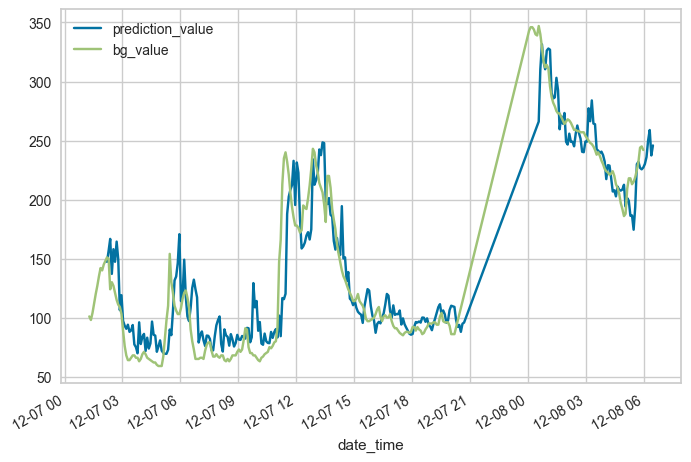

In [7]:
ax = prediction_df.plot(y='prediction_value', x='prediction_time')
measurement_df.plot(ax=ax, y='bg_value', x='date_time')


# Old

In [8]:
# from datetime import datetime, timedelta

# measurements.iloc[0].date_time + timedelta(minutes=6*5)

In [9]:
# from src.bgc_providers.ohio_bgc_provider import OhioBgcProvider
# test_provider = OhioBgcProvider()
# test_dataframe = test_provider.tsfresh_dataframe()
# mock_last_measurements = test_dataframe.head(6)
# mock_last_measurements
# features = featurize_stream_df(mock_last_measurements, 6, 6)
# features

In [10]:
# model = load_model('models/559_6_6_1_LGBMRegressor_8ef033d3-ac4b-47ba-8231-fb49991f8b7f')
# saved_model_features = model.feature_names_in_
# a = predict_model(model, correct_features(features, saved_model_features))
# a.prediction_label[0]

In [11]:
# from src.featurizers.tsfresh import TsfreshFeaturizer
# test_features = TsfreshFeaturizer(mock_last_measurements, 6, 6, plot_chunks=False, minimal_features=False)
# test_features.chunks = 1
# test_features.chunks

In [12]:
# test_features.create_feature_dataframe()
# features = test_features.feature_dataframe
# features

In [13]:
# import re
# new_names = {col: re.sub(r"[^A-Za-z0-9_]+", "", col) for col in features.columns}
# new_n_list = list(new_names.values())
# # [LightGBM] Feature appears more than one time.
# new_names = {
#     col: f"{new_col}_{i}" if new_col in new_n_list[:i] else new_col
#     for i, (col, new_col) in enumerate(new_names.items())
# }
# correct_features = features.rename(columns=new_names)
# # print(correct_features)
# for feat in saved_model_features:
#     found_in_model = feat in correct_features
#     if not found_in_model:
#         print(feat)
#         if feat != 'label':
#             correct_features[feat] = None